## Scrubber Discharge Project
Exploring the output files generated by the Salish Sea Atlantis Model
for Scrubber Discharge Project - preliminary runs (updated March 2023)

- scenario 1: 1-year discharge for Jan 2019 - Dec 2019
- scenario 2: 5-year discharge for Jan 2019 - Dec 2024
- scenario 3: 10-year discharge for Jan 2019 - Dec 2029

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot
from ssam_groups import cohorts

### Define scenario and control files

In [2]:
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Scrubber/Test_20_discharge_50y_control/outputSalishSea.nc"
scenario2019_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Scrubber/Test_20_discharge_50y_2019/outputSalishSea.nc"
scenario2024_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Scrubber/Test_20_discharge_50y_2024/outputSalishSea.nc"
scenario2029_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Scrubber/Test_20_discharge_50y_2029/outputSalishSea.nc"

In [3]:
control      = xr.open_dataset(str(control_file), decode_cf=True)
scenario2019 = xr.open_dataset(str(scenario2019_file), decode_cf=True)
scenario2024 = xr.open_dataset(str(scenario2024_file), decode_cf=True)
scenario2029 = xr.open_dataset(str(scenario2029_file), decode_cf=True)

ds_time = np.ma.filled(scenario2019.variables['t'], np.nan)

In [4]:
annual_control = control.resample(t='5Y').mean()

In [5]:
annual_scenario2019 = scenario2019.resample(t='5Y').mean()
annual_scenario2024 = scenario2024.resample(t='5Y').mean()
annual_scenario2029 = scenario2029.resample(t='5Y').mean()

time = np.ma.filled(annual_control.variables['t'], np.nan)

In [6]:
annual_scenarios = [annual_scenario2019, annual_scenario2024, annual_scenario2029]

In [7]:
#t_corrected = t - np.timedelta64(578, 'D')

start = 40 #40
end =  120 #ds_time.size-1 

event_start = np.datetime64('2019-01-01')

In [8]:
annual_end = time.size

In [9]:
scenarios = [scenario2019, scenario2024, scenario2029]

In [10]:
print(ds_time[49], ds_time[69], ds_time[89])

2019-03-13T14:00:00.000000000 2024-03-06T14:00:00.000000000 2029-02-28T14:00:00.000000000


In [11]:
days = [49, 69, 89]
data = {'2019': [], '2024': [],'2029': []}

## Water Column

Phenanthrene concentrations in each scenario

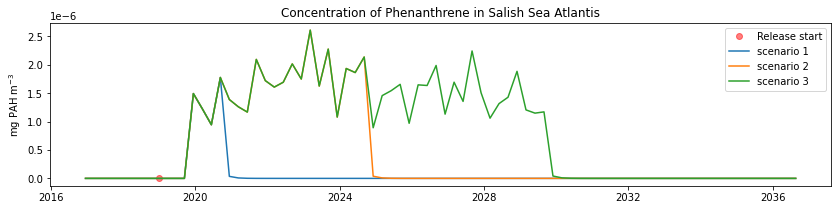

In [12]:
splot.compare_pah('Phenanthrene', scenarios, ds_time, start, 120, event_start)

### Lower trophic level

In [13]:
def pelagic_compare_scenarios(bio_group, scens, control, time, start, end, y_min=None, y_max=None): #bacteria, plankton, sharks, birds, mammals, named_fish, salmon, fish, benth_feeders

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in bio_group:
        
        bio_index = (list(bio_group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        pelagic_control = np.ma.filled(control.variables[bio_group[species] + '_N'][start:end,:,0:6], np.nan)
        pelagic_control = pelagic_control.sum(axis=2)
        pelagic_control = pelagic_control.sum(axis=1)
        control_ratio = (pelagic_control / pelagic_control-1)*100
        ax.plot(time[start:end], control_ratio, 'k', linewidth = 2)
    
        for scenario in scens:
            pelagic_oiled = np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:end,:,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ratio = (pelagic_oiled / pelagic_control-1)*100
            ax.plot(time[start:end], ratio, linewidth = 2)
       
        plt.ylabel('Percent (%) change', fontsize=12)
        ax.legend(['control', 'scenario 1', 'scenario 2', 'scenario 3', 'scenario 4'])
        ax.set_title(species)
        ax.set_ylim([y_min, y_max]);

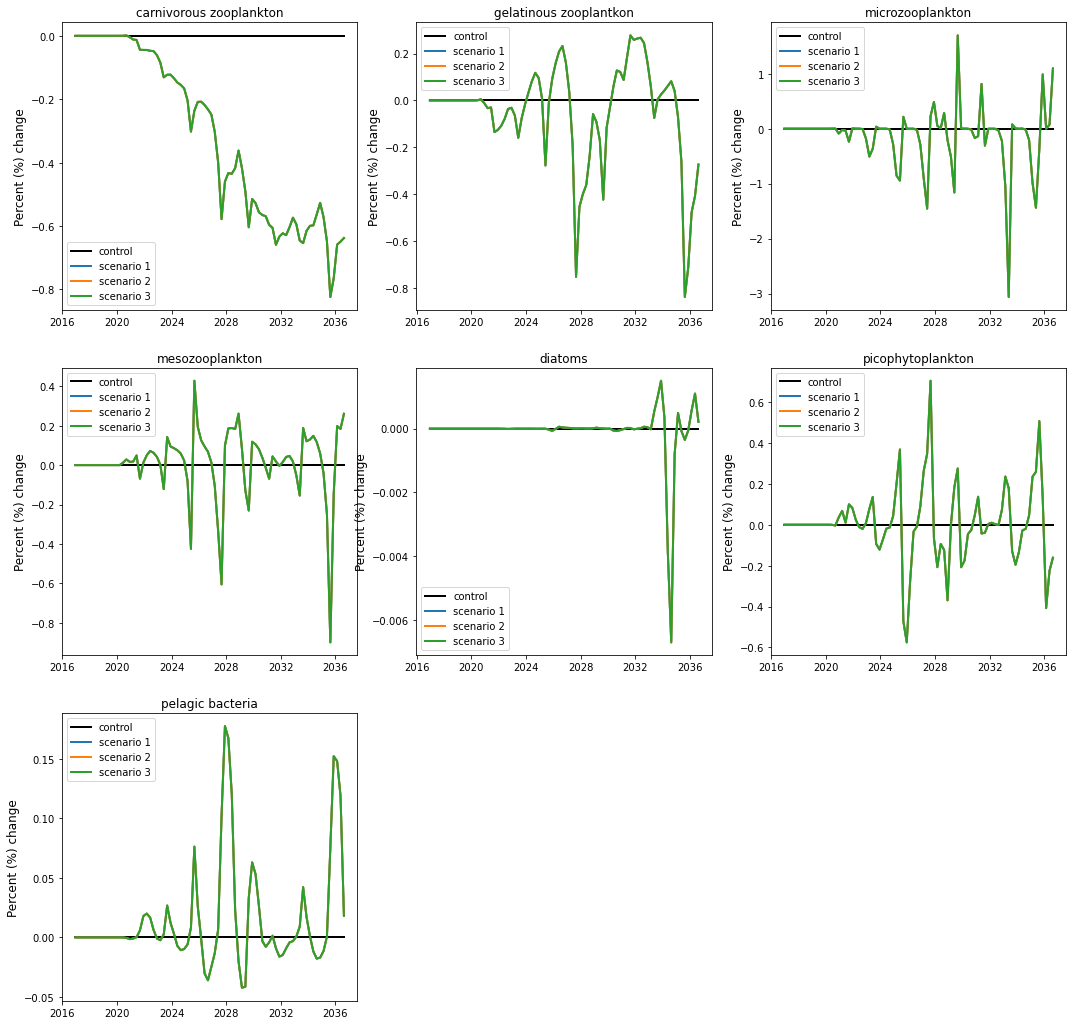

In [14]:
pelagic_compare_scenarios(groups.plankton, scenarios, control, ds_time, start, end, y_min=None, y_max=None)

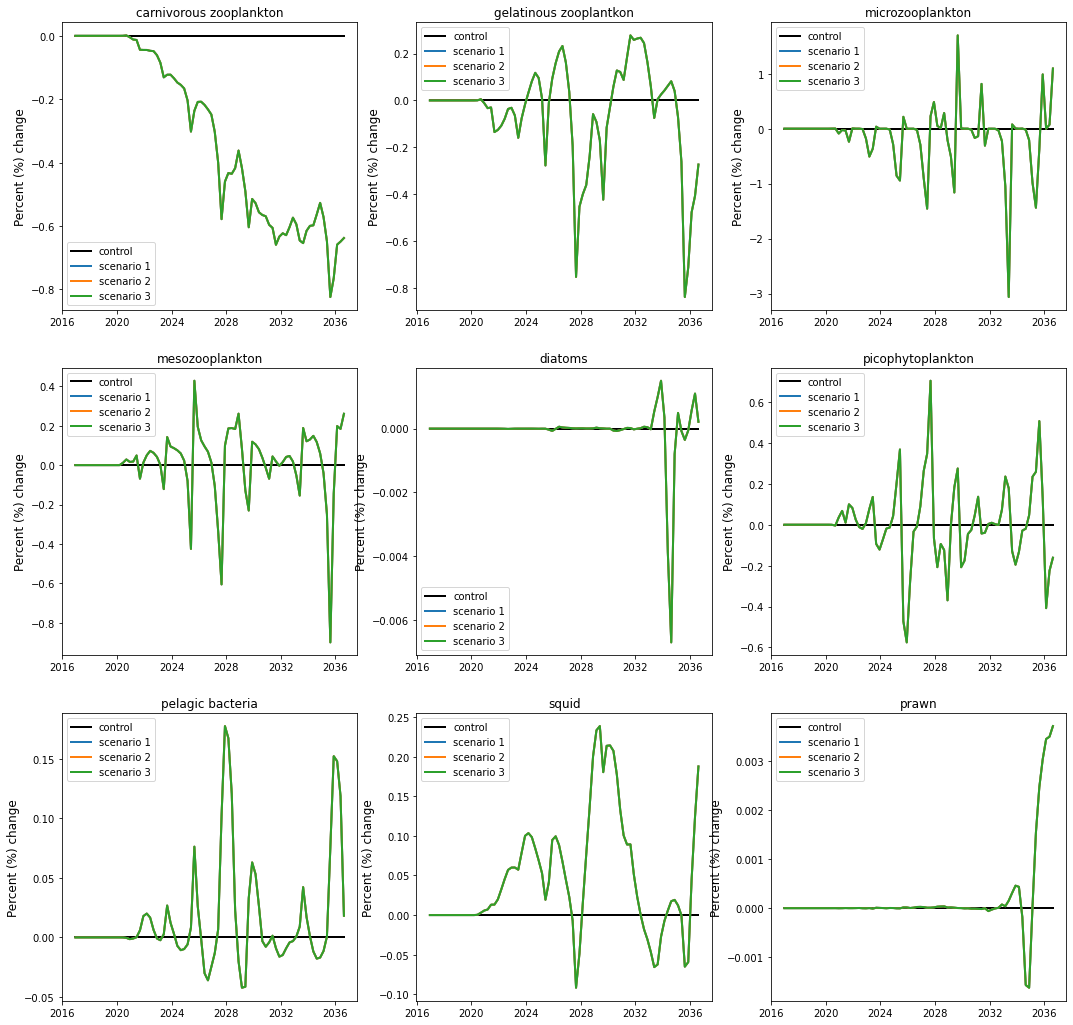

In [17]:
pelagic_compare_scenarios(groups.planktonic, scenarios, control, ds_time, start, end, y_min=None, y_max=None)

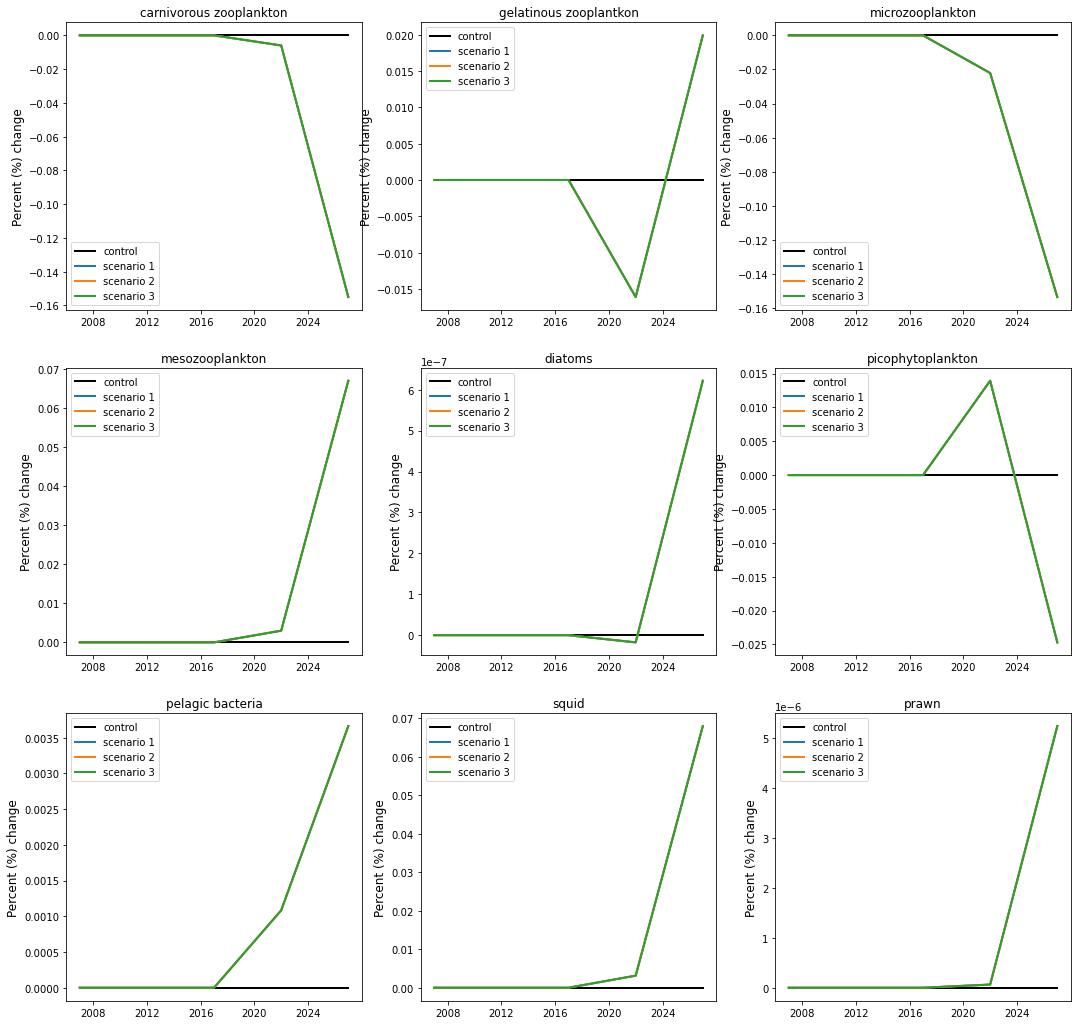

In [18]:
pelagic_compare_scenarios(groups.planktonic, annual_scenarios, annual_control, time, 0, 5, y_min=None, y_max=None)

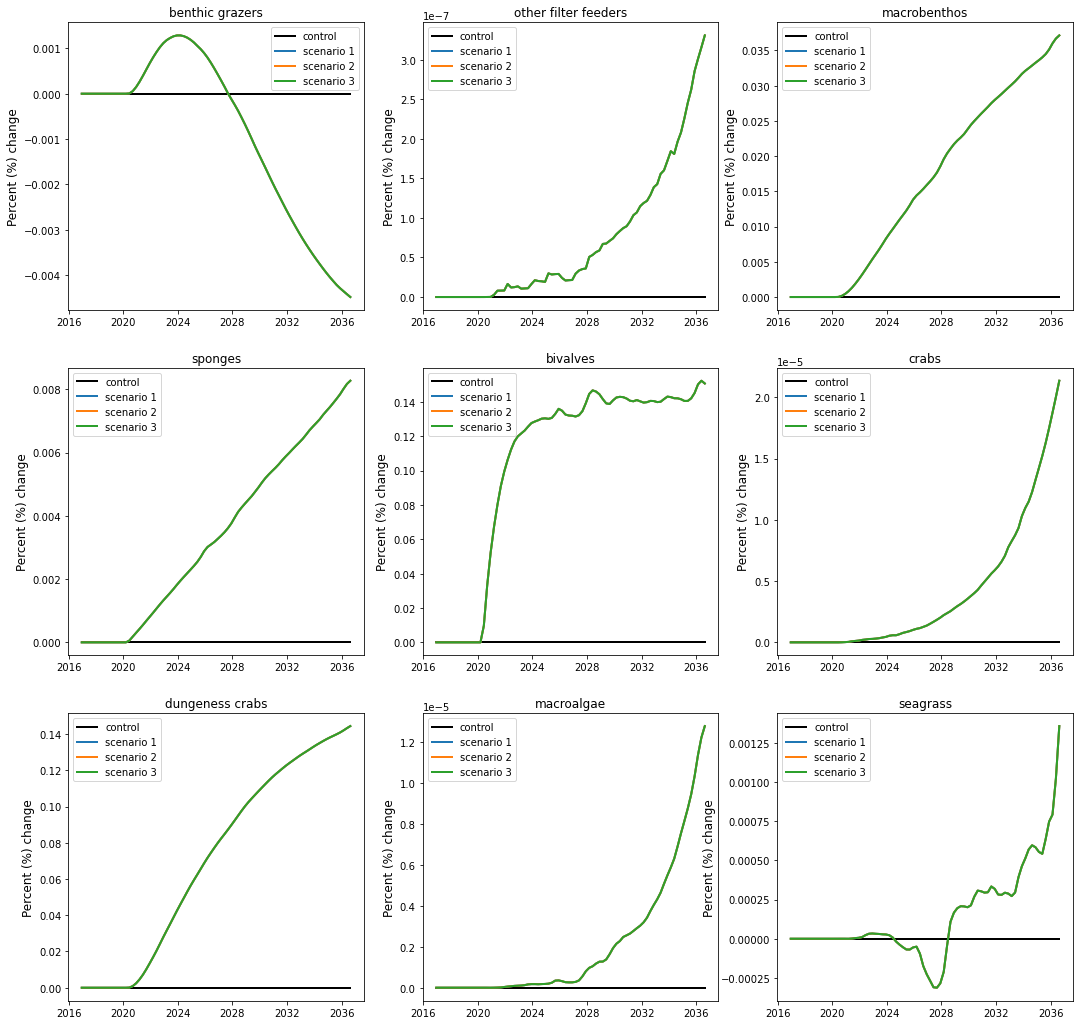

In [19]:
splot.benthic_compare_scenarios(groups.benthos, scenarios, control, ds_time, start, end, y_min=None, y_max=None)

In [20]:
def plot_pelagic_biomass(group, scenarios, control, time, start, end, event_start, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 14), facecolor='white') #constrained_layout=True
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1], figure=fig) 

    for species in group:
        bio_index = (list(group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
    
        ax = fig.add_subplot(gs[position])
        ax.tick_params(labelsize=12)
        ax.set_ylabel('mg N m$^{-3}$') 
        
        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,:,0:5], np.nan)
        p_control = pelagic_control.sum(axis=1)
        p_control = p_control.sum(axis=1)
        
        for scenario in scenarios:
            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,:,0:5], np.nan) # tonnes
            p_oiled = pelagic_oiled.sum(axis=1)
            p_oiled = p_oiled.sum(axis=1)
            p_max = p_oiled.max()
            p_min = p_oiled.min()
            ax.plot(time[start:end], p_oiled, label='scenario', linewidth = 2)
        
        ax.set_title(str(group[species]), fontsize = 12)
        ax.plot(time[start:end], p_control, '-.k', label='control',linewidth = 2) 
        ax.plot([event_start,event_start],[p_min, p_max], 'r', label='event start', alpha=0.5)   
        ax.set_ylim([y_min, y_max])
    ax.legend(['1yr discharge','5y discharge', '10yr discharge','control: no discharge','event start'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);  # to place the legend outside


In [ ]:

plot_pelagic_biomass(groups.planktonic, scenarios, control, ds_time, start, 140, event_start)

In [ ]:
plot_pelagic_biomass(groups.planktonic, annual_scenarios, annual_control, time, 0, annual_end, event_start)

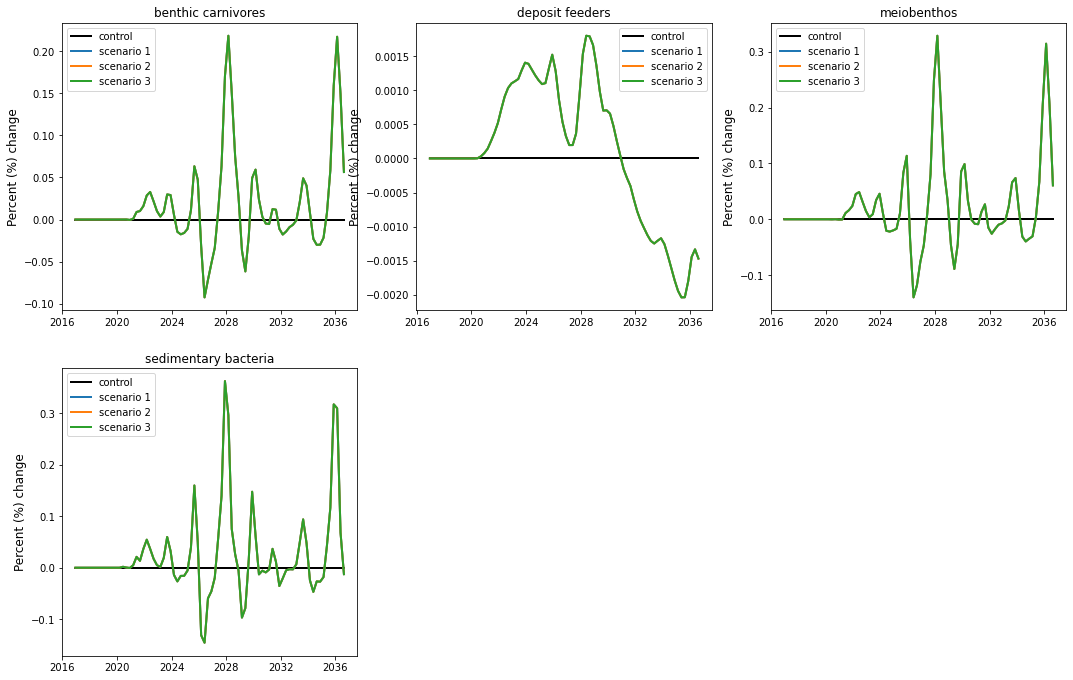

In [23]:
splot.sediment_compare_scenarios(groups.sediment_feeders, scenarios, control, ds_time, start, 120)


Years 2019-2029

In [15]:
print(ds_time[52], ds_time[72], ds_time[92])

2019-12-11T14:00:00.000000000 2024-12-04T14:00:00.000000000 2029-11-28T14:00:00.000000000


In [16]:
end2029 =  92

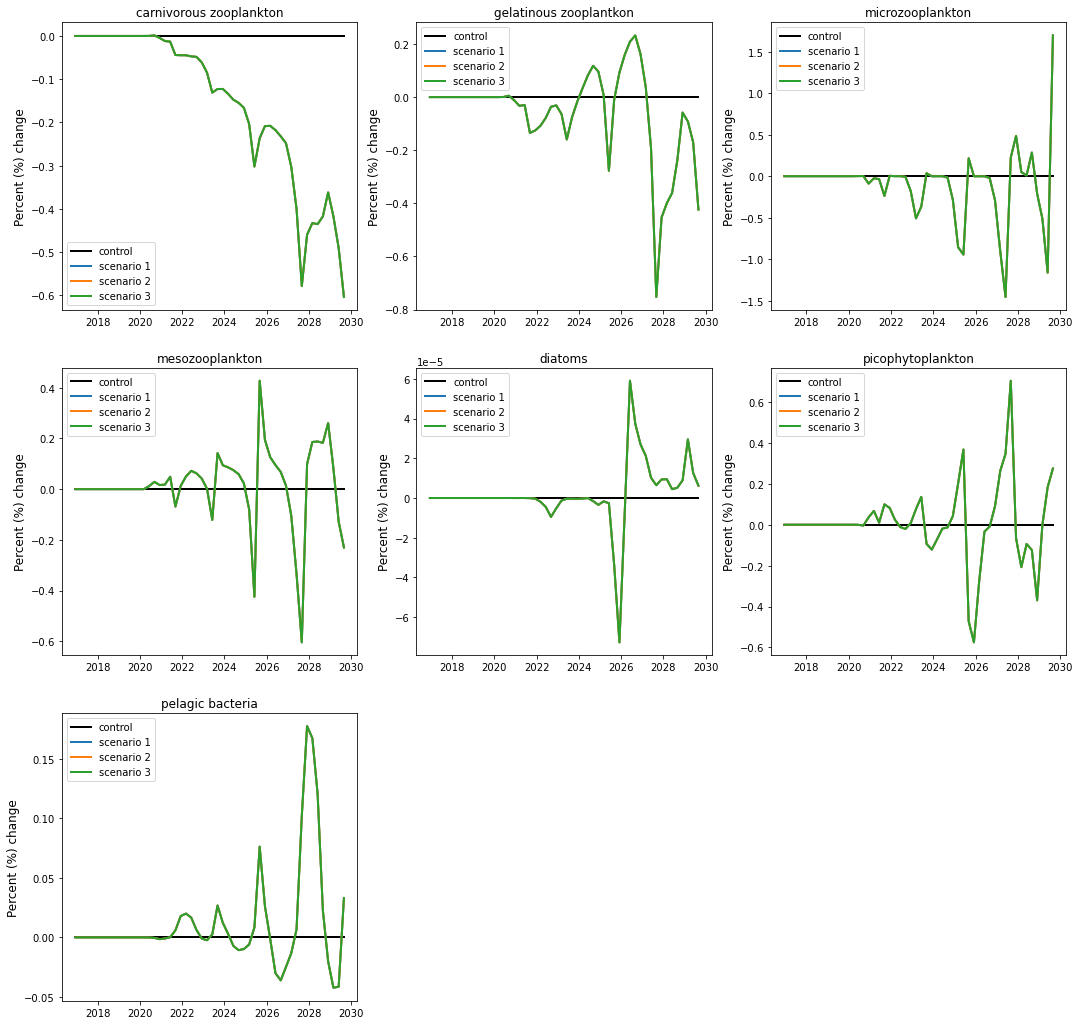

In [17]:
pelagic_compare_scenarios(groups.plankton, scenarios, control, ds_time, start, end2029, y_min=None, y_max=None)

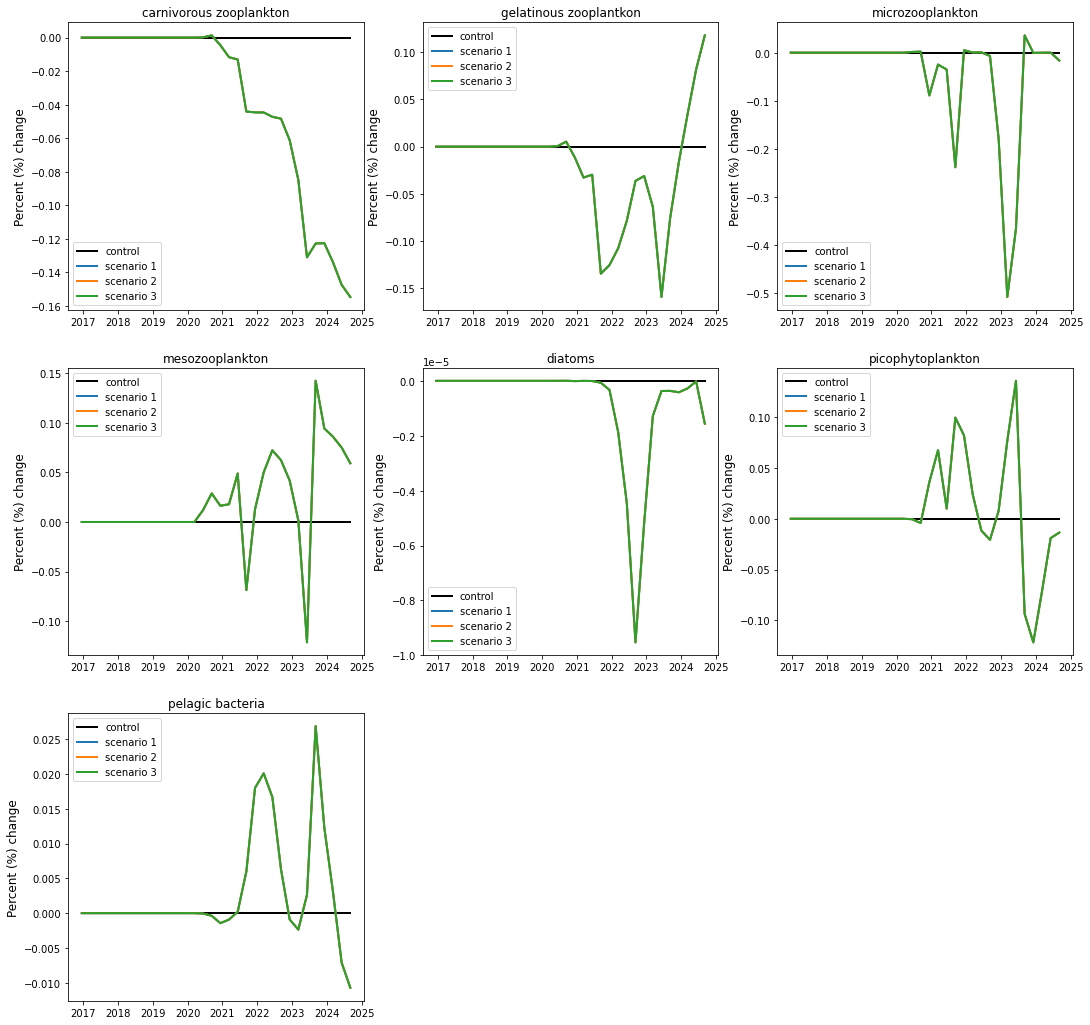

In [18]:
end2024 =  72 #t.size-1
pelagic_compare_scenarios(groups.plankton, scenarios, control, ds_time, start, end2024)

In [ ]:
print(time[55], time[75], time[95], time[220] )

all times within each year

In [29]:
initial_year = [51,52,53,54,55]
fifth_year = [71,72,73,74,75]
tenth_year = [91,92,93,94,95]
#fiftieth_year = [252,253,254,255,256]

In [30]:
days = [initial_year, fifth_year, tenth_year] #, fiftieth_year]
data = {'initial time of discharge': [], '5 years later': [],'10 years later': []} #, '50 years later': []}

In [31]:
def boxplot_pelagic(group, scenarios, control, days, data_labels, x_lim=None, bio_colours=['#063764','#0b5394','#3d85c6','#6fa8dc','#9fc5e8']): #bacteria, plankton
    
    for scenario in scenarios:
        df = pd.DataFrame(data_labels)
        spp = []
        
        for species in group:
            results = list()
            for day in days:
                p_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][day,:,0:6], np.nan) # tonnes, take only water column layers
                p_control = np.ma.filled(control.variables[group[species] + '_N'][day,:,0:6], np.nan)
                p_oiled = p_oiled.sum(axis=0)
                p_oiled = p_oiled.sum(axis=0)
                p_oiled = p_oiled.sum(axis=0)
                p_control = p_control.sum(axis=0)
                p_control = p_control.sum(axis=0)
                p_control = p_control.sum(axis=0)
                ratio = (p_oiled/p_control-1)*100
                results.append(ratio)
            spp.append(group[species])
            df.loc[len(df.index)] = results
        df['bio_group'] = spp
        df1 = df.set_index('bio_group')

        df1.plot(kind="barh", subplots=True, layout=(1,len(days)), figsize=(15,4), sharey=True, sharex=True, color=bio_colours, legend=False, #ax=ax,
            xlabel='Pelagic Groups', ylabel=None, title='Percent (%) Change Relative to Control for Select Pelagic Groups', xlim=x_lim); 


Annual comparisons

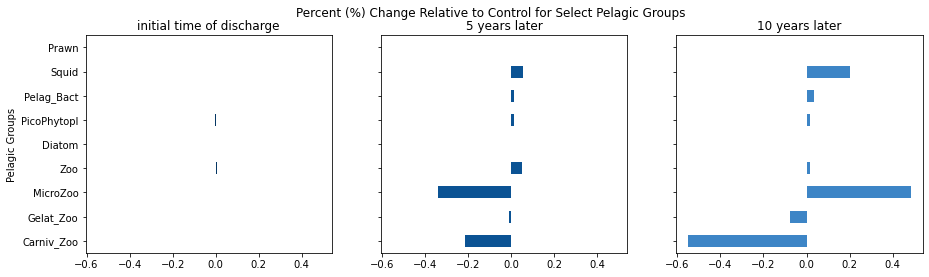

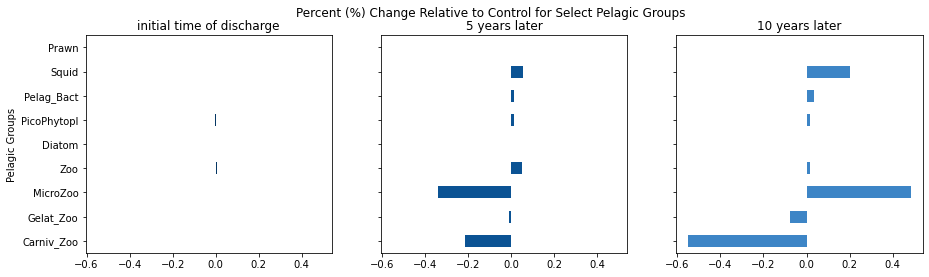

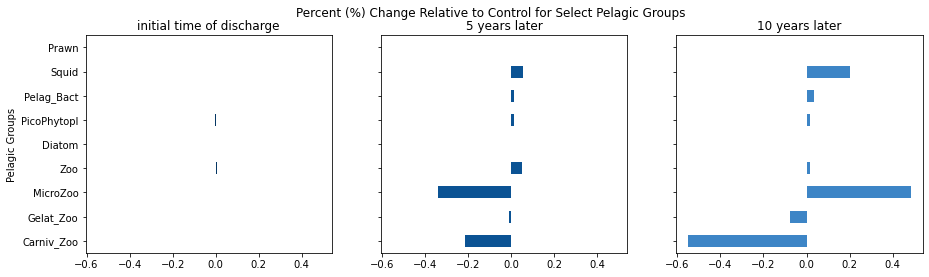

In [32]:
boxplot_pelagic(groups.planktonic, scenarios, control, days, data, x_lim=None)

Cumulative from the start

In [ ]:
for scenario in scenarios:
    splot.boxplot_pelagic(groups.planktonic,scenario,control,start,end,data, x_lim=[-15,15]) # cumulative from the start

## five-year averaged data

In [23]:
initial_year = [51,52,53,54,55]
fifth_year = [71,72,73,74,75]
tenth_year = [91,92,93,94,95]
#fiftieth_year = [252,253,254,255,256]

days = [initial_year, fifth_year, tenth_year] #, fiftieth_year]
data = {'initial time of discharge': [], '5 years later': [],'10 years later': []} #, '50 years later': []}

In [20]:
def avg_pelagic_boxplot_5(group):
    bio_colours=['#063764','#0b5394','#3d85c6','#6fa8dc','#9fc5e8']
    names = ['discharge 2019 only','discharge 2019-2024', 'discharge 2019-2029']
    cum_years = [3,4,5]
    for scenario, name in zip(annual_scenarios, names):
        df = pd.DataFrame(data)
        spp = []
        
        for species in group:
            results = list()
            for year in cum_years:
                p_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][year,:,0:5], np.nan) # tonnes, take only water column layers
                p_control = np.ma.filled(annual_control.variables[group[species] + '_N'][year,:,0:5], np.nan)
                p_oiled = p_oiled.sum(axis=0)
                p_oiled = p_oiled.sum(axis=0)
                p_control = p_control.sum(axis=0)
                p_control = p_control.sum(axis=0)
                ratio = (p_oiled/p_control-1)*100
                results.append(ratio)
            spp.append(group[species])
            df.loc[len(df.index)] = results
        df['bio_group'] = spp
        df1 = df.set_index('bio_group')

        df1.plot(kind="barh", subplots=True, layout=(1,len(days)), title=name, figsize=(15,4), sharey=True, sharex=True, color=bio_colours, legend=False, #ax=ax,
            xlabel='Pelagic Groups', ylabel=None, xlim=[-25,15]); 

In [14]:
names = ['discharge 2019 only','discharge 2019-2024', 'discharge 2019-2029']

In [ ]:
avg_pelagic_boxplot_5(groups.planktonic)

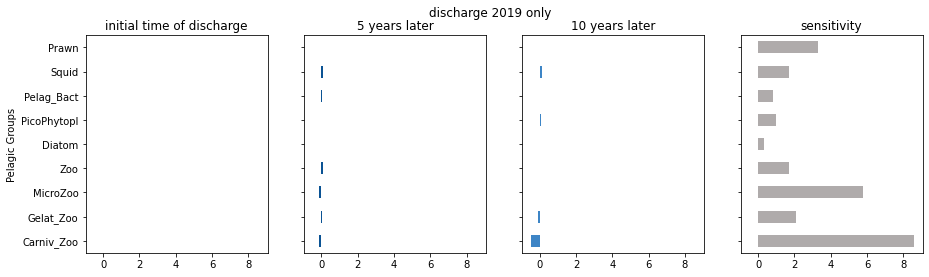

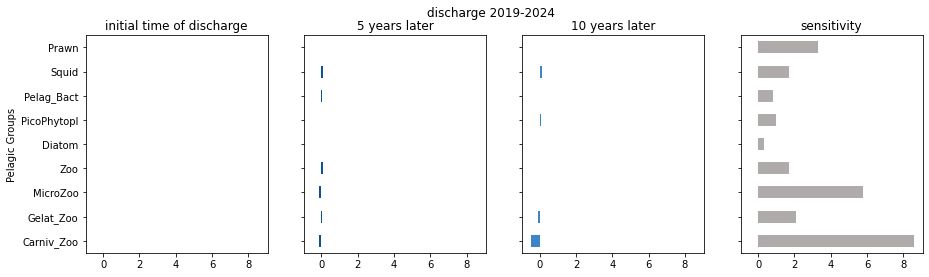

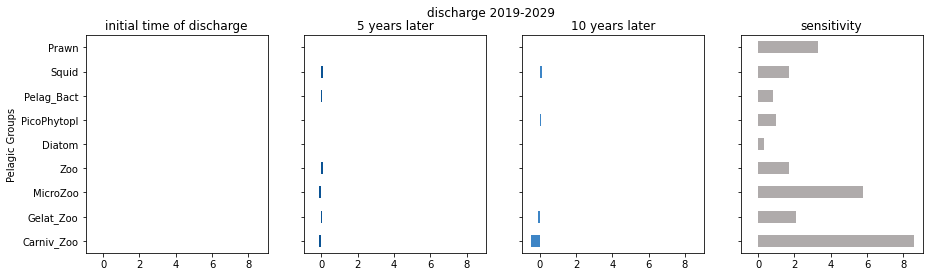

In [15]:
# To add model sensitivity range to plots (updated to v6699)
group = groups.planktonic
sensitivity_planktonic = {
    'carnivorous zooplankton':8.6, 'gelatinous zooplantkon':2.1, 'microzooplankton':5.8,
    'mesozooplankton':1.7, 'diatoms':0.3, 'picophytoplankton':1.0, 'pelagic bacteria':0.8,
    'squid':1.7, 'prawn': 3.3, }
bio_colours=['#063764','#0b5394','#3d85c6','#AFABAB'] #'#6fa8dc'
cum_years = [3,4,5] #13
for scenario, name in zip(annual_scenarios, names):
    df = pd.DataFrame(data)
    spp = []
    sensitivity_results = []
    
    for species in group:
        results = list()
        for year in cum_years:
            p_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][year,:,0:6], np.nan) # tonnes, take only water column layers
            p_control = np.ma.filled(annual_control.variables[group[species] + '_N'][year,:,0:6], np.nan)
            p_oiled = p_oiled.sum(axis=0)
            p_oiled = p_oiled.sum(axis=0)
            p_control = p_control.sum(axis=0)
            p_control = p_control.sum(axis=0)
            ratio = (p_oiled/p_control-1)*100
            results.append(ratio)
        spp.append(group[species])
        sensitivity_results.append(sensitivity_planktonic[species])
        df.loc[len(df.index)] = results
    df['bio_group'] = spp
    df['sensitivity'] = sensitivity_results
    df1 = df.set_index('bio_group')

    df1.plot(kind="barh", subplots=True, layout=(1,len(days)+1), title=name, figsize=(15,4), sharey=True, sharex=True, color=bio_colours, legend=False, #ax=ax,
        xlabel='Pelagic Groups', ylabel=None, xlim=None); 

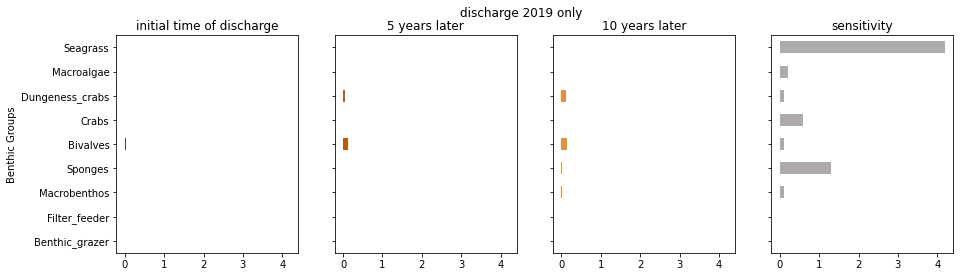

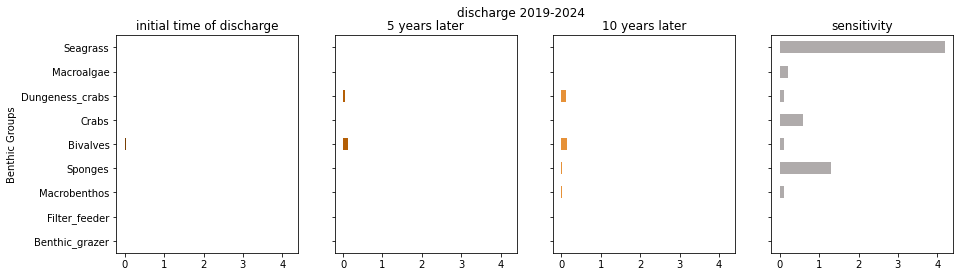

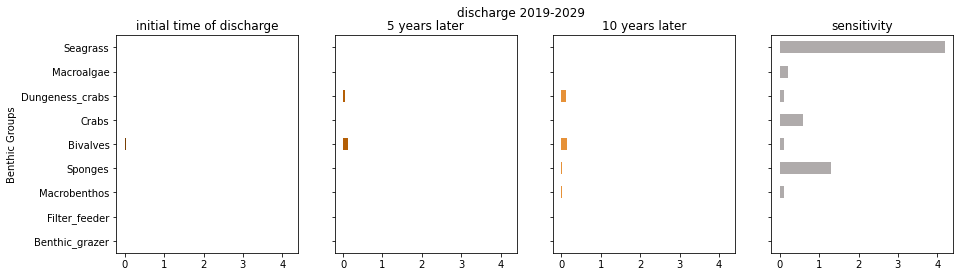

In [17]:
group = groups.benthos 
bio_colours=['#783f04','#b45f06','#e69138','#AFABAB'] #,'#f6b26b','#f9cb9c']
sensitivity_benthic = { 
    'benthic grazers':0.0, 'other filter feeders': 0.0, 'macrobenthos':0.1,  
    'sponges':1.3, 'bivalves':0.1, 'crabs':0.6, 'dungeness crabs':0.1,
    'macroalgae':0.2, 'seagrass':4.2, }

cum_years = [3,4,5] #13
for scenario, name in zip(annual_scenarios, names):
    df = pd.DataFrame(data)
    spp = []
    sensitivity_results = []
    
    for species in group:
        results = list()
        for year in cum_years:
            p_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][year,:], np.nan) # tonnes, take only water column layers
            p_control = np.ma.filled(annual_control.variables[group[species] + '_N'][year,:], np.nan)
            p_oiled = p_oiled.sum(axis=0)
            p_control = p_control.sum(axis=0)
            ratio = (p_oiled/p_control-1)*100
            results.append(ratio)
        spp.append(group[species])
        df.loc[len(df.index)] = results
        sensitivity_results.append(sensitivity_benthic[species])
    df['bio_group'] = spp
    df['sensitivity'] = sensitivity_results
    df1 = df.set_index('bio_group')

    df1.plot(kind="barh", subplots=True, layout=(1,len(days)+1), title=name, figsize=(15,4), sharey=True, sharex=True, color=bio_colours, legend=False, #ax=ax,
        xlabel='Benthic Groups', ylabel=None, xlim=None); 

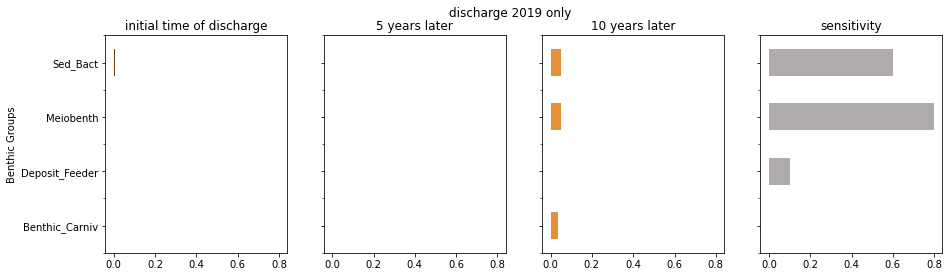

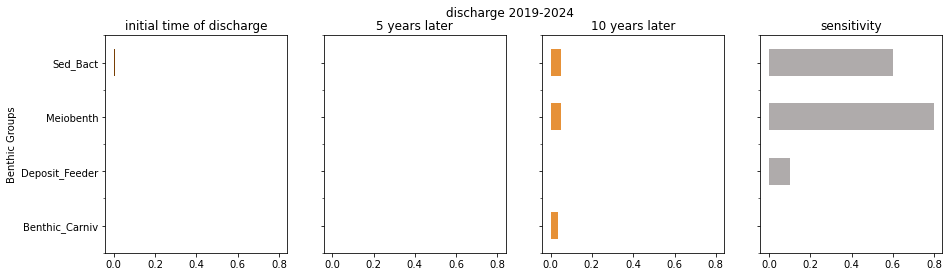

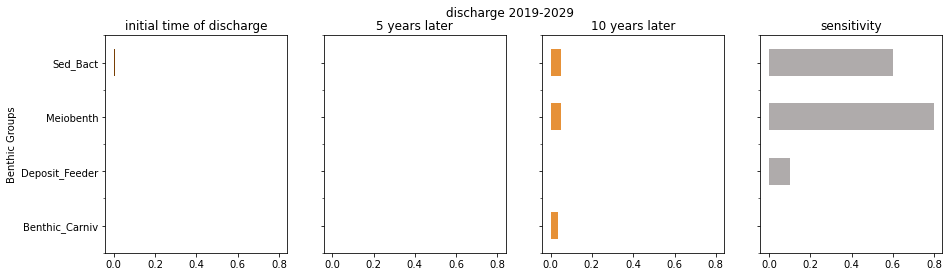

In [24]:
group = groups.sediment_feeders
bio_colours=['#783f04','#b45f06','#e69138','#AFABAB'] #,'#f6b26b','#f9cb9c']
sensitivity_sediment_feeders = {
    'benthic carnivores':0.0, 'deposit feeders':0.1, 'meiobenthos':0.8, 'sedimentary bacteria': 0.6,}

cum_years = [3,4,5] #13
for scenario, name in zip(annual_scenarios, names):
    df = pd.DataFrame(data)
    spp = []
    sensitivity_results = []
    
    for species in group:
        results = list()
        for year in cum_years:
            p_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][year,:,6], np.nan) # tonnes, take only water column layers
            p_control = np.ma.filled(annual_control.variables[group[species] + '_N'][year,:,6], np.nan)
            p_oiled = p_oiled.sum(axis=0)
            p_control = p_control.sum(axis=0)
            ratio = (p_oiled/p_control-1)*100
            results.append(ratio)
        spp.append(group[species])
        df.loc[len(df.index)] = results
        sensitivity_results.append(sensitivity_sediment_feeders[species])
    df['bio_group'] = spp
    df['sensitivity'] = sensitivity_results
    df1 = df.set_index('bio_group')
    
    df1.plot(kind="barh", subplots=True, layout=(1,len(days)+1), title=name, figsize=(15,4), sharey=True, sharex=True, color=bio_colours, legend=False, #ax=ax,
        xlabel='Benthic Groups', ylabel=None, xlim=None); 

In [ ]:
avg_pelagic_boxplot_5(groups.mammals)

In [ ]:
avg_pelagic_boxplot_5(groups.salmon)

In [ ]:
avg_pelagic_boxplot_5(groups.named_fish)

In [ ]:
avg_pelagic_boxplot_5(groups.sediment_feeders)

5-year average, 1st year of discharge, exploring the planktonic species, which are the only one to respond within this timeframe

In [28]:
def average_depth_plot(group):
    for year in cum_years[0:2]:
        fig = plt.figure(figsize=(15, 15), facecolor='white', constrained_layout=True)
        gs = plt.GridSpec(3, 4, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1], figure=fig) 

        discharge_time = {0:'1st year of discharge', 1:'5 years later', 2:'10 years later', 3:'50 years later',}
        depth = [400, 250, 100, 50, 25, 0]

        for species in group:

            bio_index = (list(group).index(species))

            if bio_index < 4:
                position = 0, bio_index
            elif bio_index > 7: 
                position = 2, bio_index-8
            else :
                position = 1, bio_index-4

            ax = fig.add_subplot(gs[position])
            
            pelagic_control = np.ma.filled(annual_control.variables[group[species] + '_N'][year,:,0:6], np.nan)
            p_control = pelagic_control.sum(axis=0)
            ax.set_ylim(250, 0)  # decreasing depth
            
            for scenario in annual_scenarios:

                pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][year,:,0:6], np.nan) # tonnes, take only water column layers
                p_oiled = pelagic_oiled.sum(axis=0)
                ax.plot(p_oiled, depth, linewidth = 2)
            ax.plot(p_control, depth, '-.k', linewidth = 2, alpha=0.8)
            ax.set_title(species);
            ax.set_ylabel('depth (m)')
            ax.set_xlabel('5y average mg N m$^{-3}$')
        ax.legend(['1y discharge','5y discharge','10y discharge','control: no discharge'],bbox_to_anchor=(1.05, 1), loc='lower right');  # place the legend outside)
        fig.suptitle(discharge_time[cum_years.index(year)], fontsize=14)

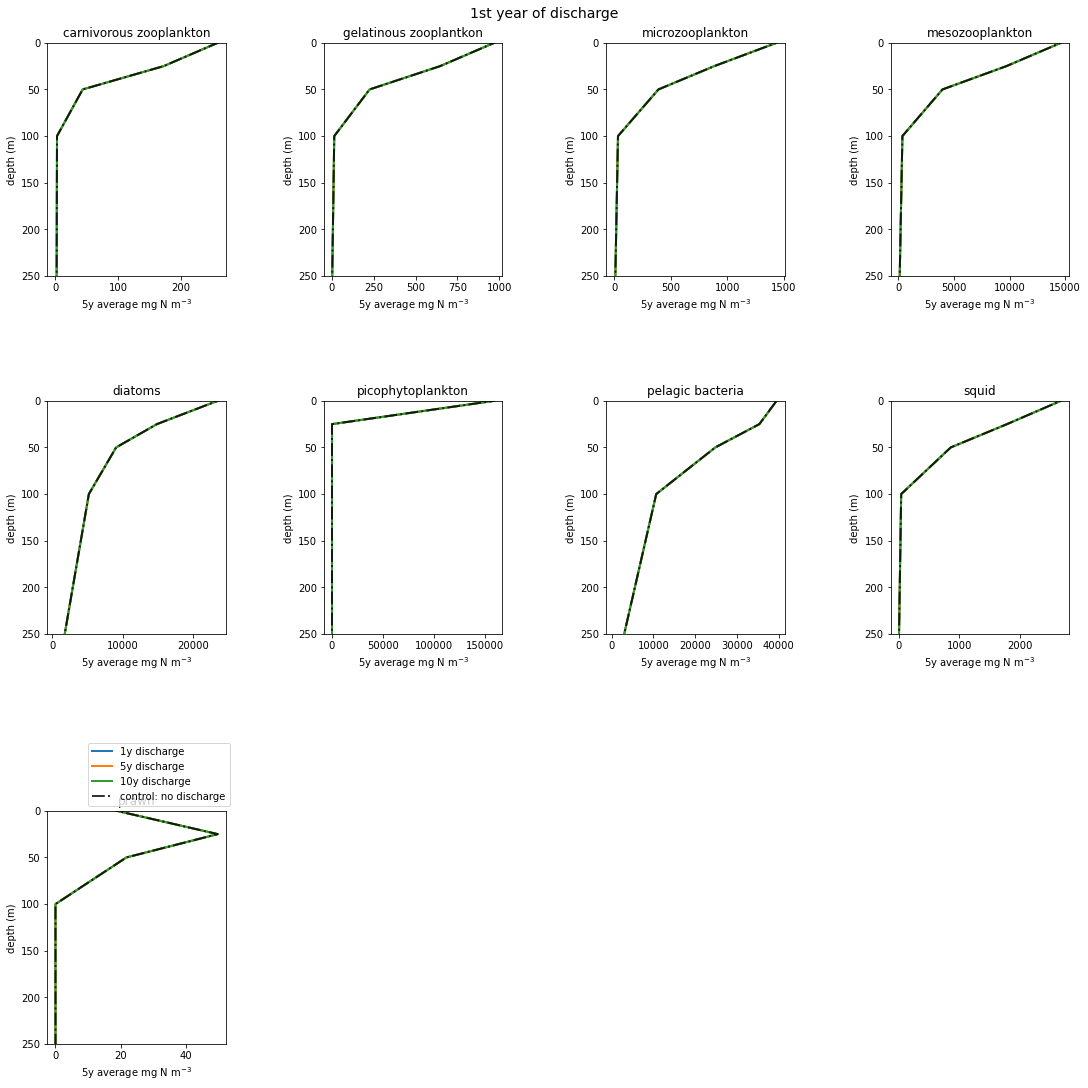

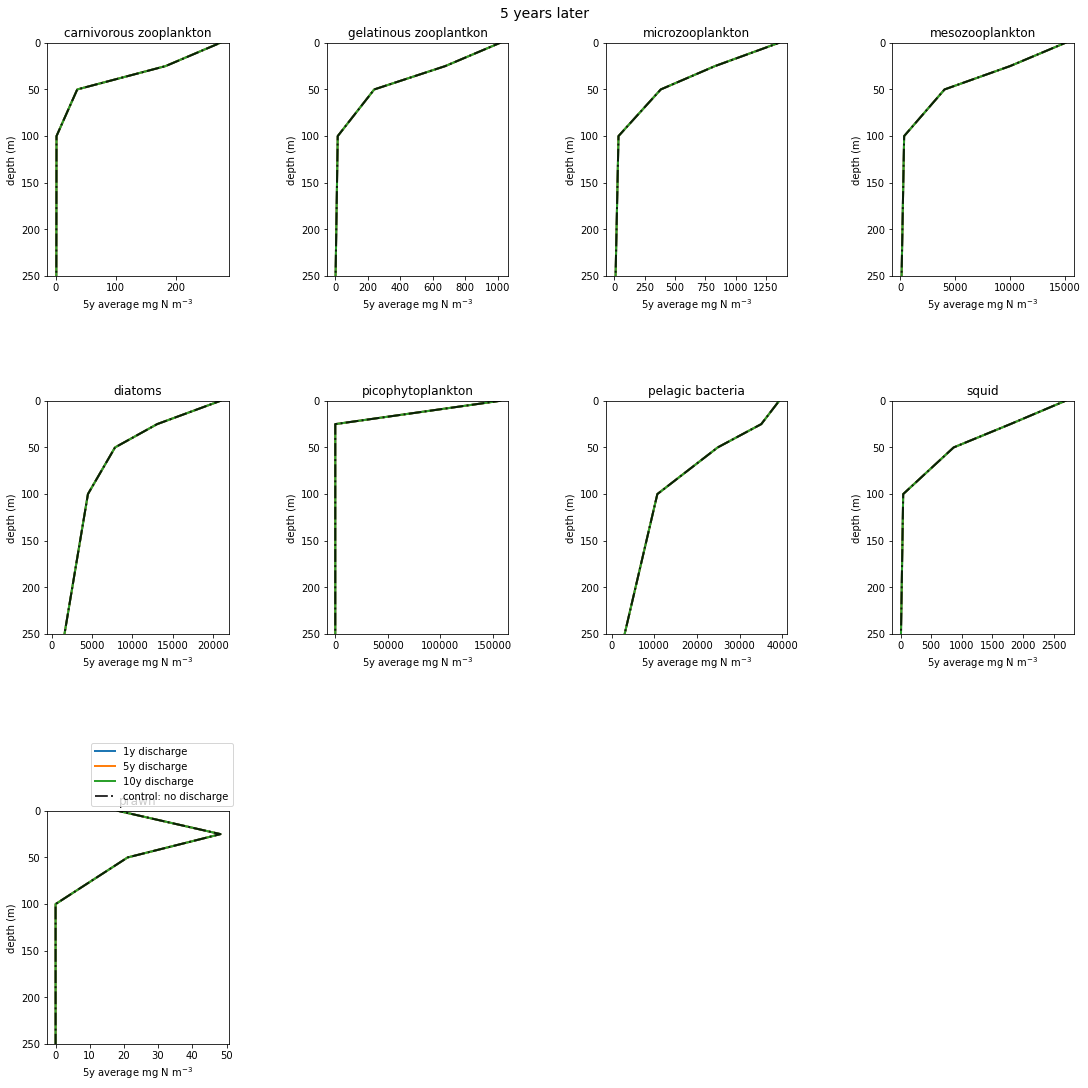

In [29]:
average_depth_plot(groups.planktonic)

### Regional difference?

In [30]:
#regions by Atlantis boxes
JdF_west = [1,2,3,4]
JdF_east = [5,6,7,8,9,10,11]
Haro_Boundary = [60,33,34,35,36]
SoG_south = [54,64,68,79]
SoG_center = [80,81,82,83,84,85]
SoG_north = [88,92.98,101,102]
PS_main = [20,21,23,26]

In [31]:
def avg_pelagic_boxplot_region(group, region, xlim=None):
    bio_colours=['#063764','#0b5394','#3d85c6','#6fa8dc','#9fc5e8']
    cum_years = [3,4,5]
    for scenario, name in zip(annual_scenarios, names):
        df = pd.DataFrame(data)
        spp = []
        
        for species in group:
            results = list()
            for year in cum_years:
                p_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][year,region,0:6], np.nan) # tonnes, take only water column layers
                p_control = np.ma.filled(annual_control.variables[group[species] + '_N'][year,region,0:6], np.nan)
                p_oiled = p_oiled.sum(axis=0)
                p_oiled = p_oiled.sum(axis=0)
                p_control = p_control.sum(axis=0)
                p_control = p_control.sum(axis=0)
                ratio = (p_oiled/p_control-1)*100
                results.append(ratio)
            spp.append(group[species])
            df.loc[len(df.index)] = results
        df['bio_group'] = spp
        df1 = df.set_index('bio_group')

        df1.plot(kind="barh", subplots=True, layout=(1,len(days)), title=name, figsize=(15,4), sharey=True, sharex=True, color=bio_colours, legend=False, #ax=ax,
            xlabel='Pelagic Groups', ylabel=None, xlim=xlim); 

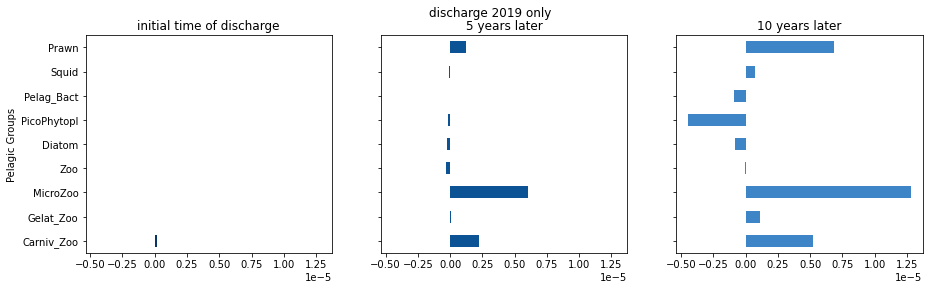

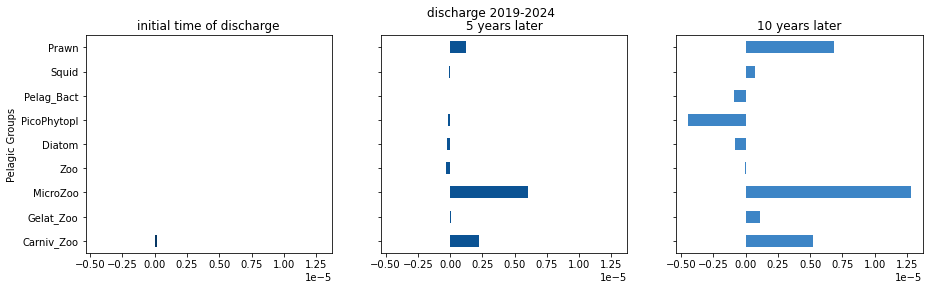

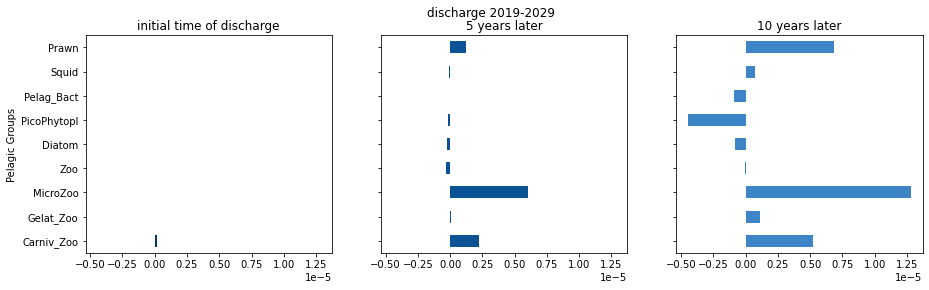

In [32]:
avg_pelagic_boxplot_region(groups.planktonic, SoG_center, xlim=None)

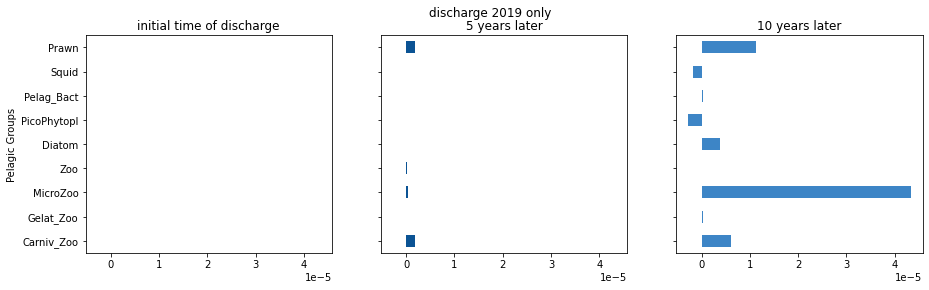

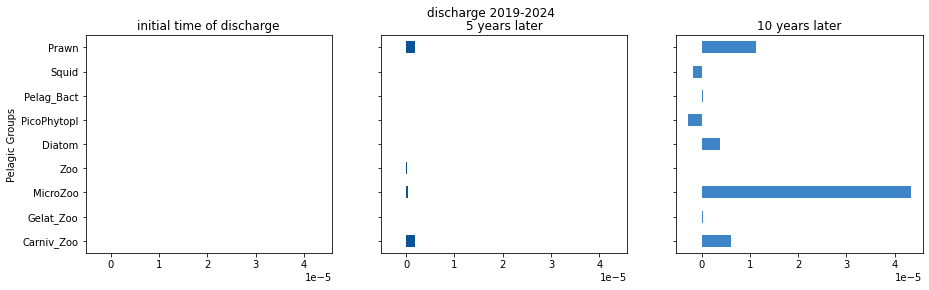

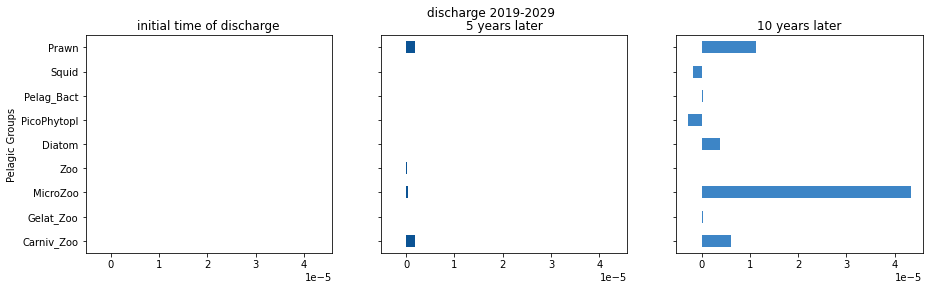

In [55]:
avg_pelagic_boxplot_region(groups.planktonic, SoG_south, xlim=None)

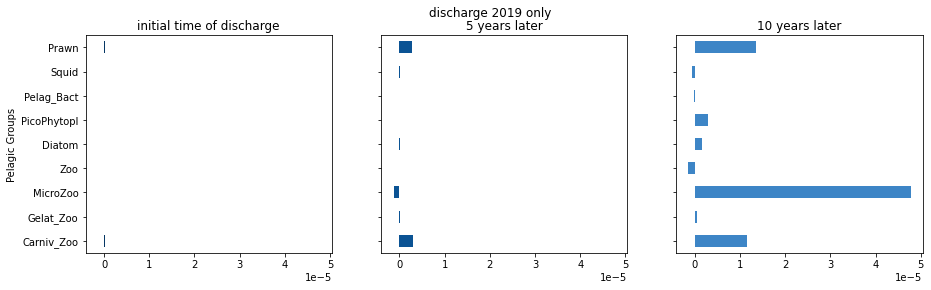

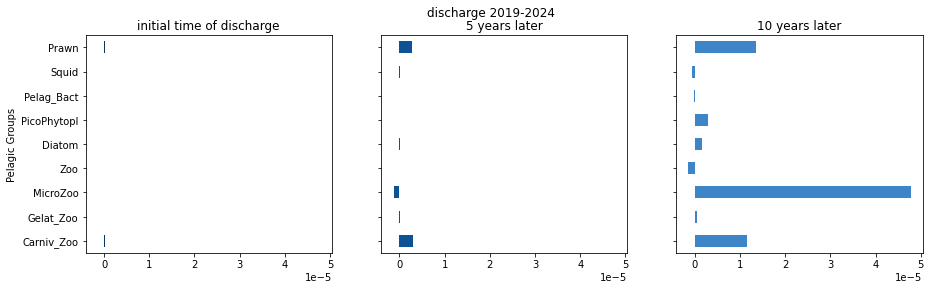

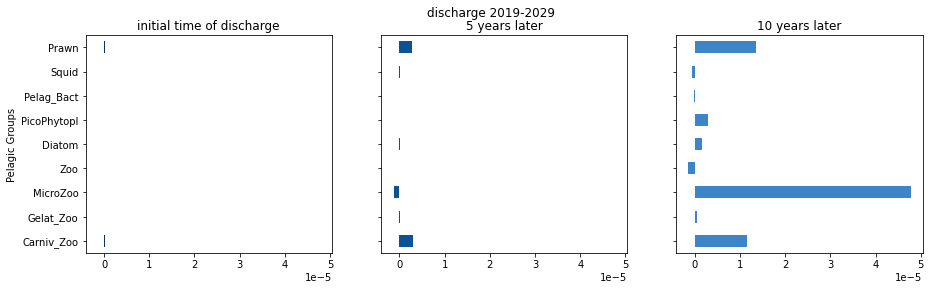

In [56]:
avg_pelagic_boxplot_region(groups.planktonic, Haro_Boundary, xlim=None)

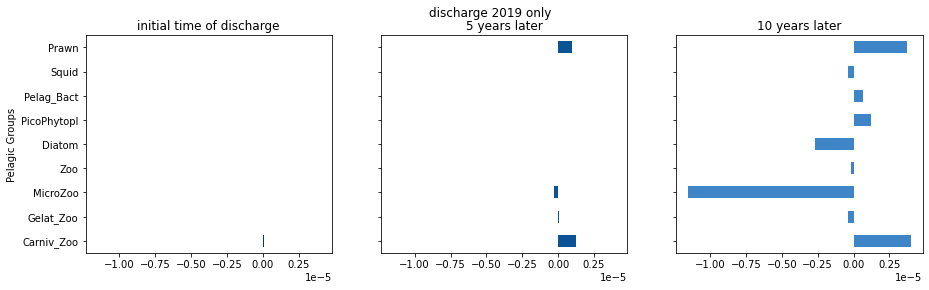

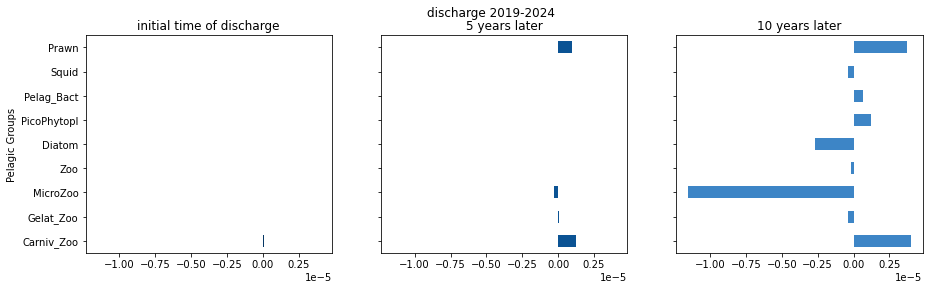

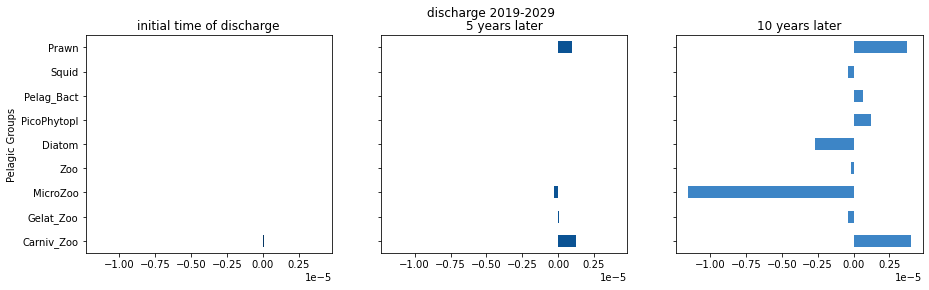

In [57]:
avg_pelagic_boxplot_region(groups.planktonic, JdF_east, xlim=None)

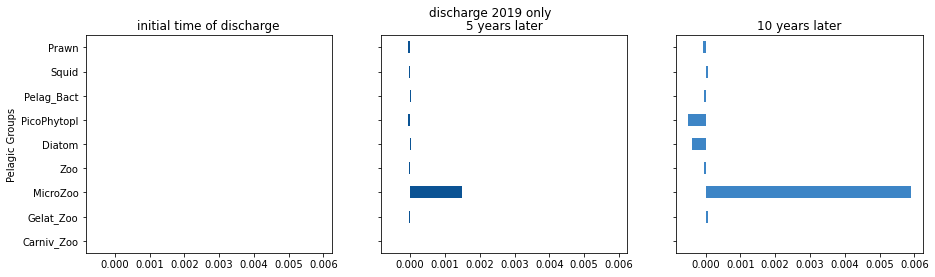

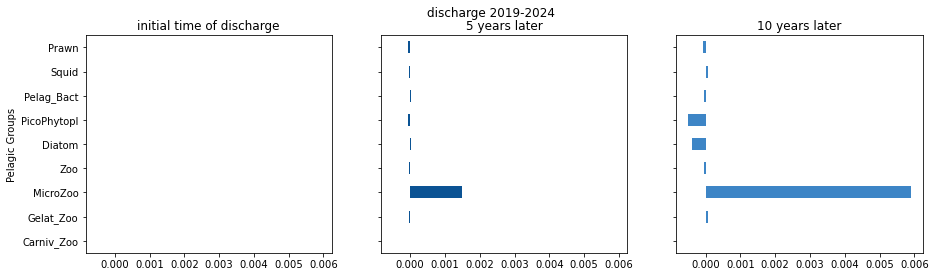

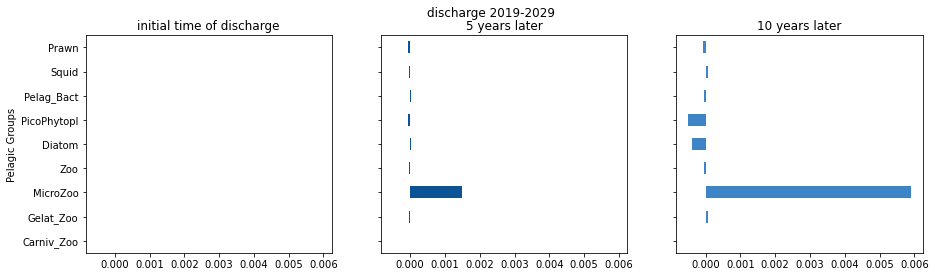

In [58]:
avg_pelagic_boxplot_region(groups.planktonic, JdF_west, xlim=None)

## Internal Phenanthrene concentrations

#### Functions

In [37]:
def tissue_concentration(group, scenarios):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scenarios: 
            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_Phenanthrene'][:,:,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ax.plot(time, pelagic_oiled, linewidth = 2) #semilogy
        
        plt.ylabel('mg PAH as Phe', fontsize=12)
        ax.set_title(species);
    fig.legend(['1yr discharge','5y discharge', '10yr discharge'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12); 

In [36]:
def tissue_juveniles_concentration(group, scenarios):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scenarios:
            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '1_Phenanthrene'][:,:,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ax.plot(time, pelagic_oiled, linewidth = 2) #semilogy
        
        plt.ylabel('mg PAH as Phe', fontsize=12)
        ax.set_title(species);
    fig.legend(['1yr discharge','5y discharge', '10yr discharge'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12); 

In [35]:
def tissue_adults_concentration(group, scenarios):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scenarios:
            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '5_Phenanthrene'][:,:,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ax.plot(time, pelagic_oiled, linewidth = 2) #semilogy
        
        plt.ylabel('mg PAH as Phe', fontsize=12)
        ax.set_title(species);
    fig.legend(['1yr discharge','5y discharge', '10yr discharge'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12); 

In [34]:
def tissue_vertebrate_concentration(group, scenarios):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:

        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        numCohorts = cohorts[group[species]]

        oiled_cohort = np.zeros(len(time))

        for scenario in scenarios:
            for cohort in range (1, numCohorts+1):

                new_species = group[species] + str(cohort)
            
                oiled_species = np.ma.filled(scenario.variables[new_species + '_Phenanthrene'][:,:,:], np.nan)
                oiled_species = oiled_species.sum(axis=2)
                oiled_species = oiled_species.sum(axis=1)

                oiled_cohort = oiled_cohort + oiled_species
            ax.plot(time, oiled_cohort, linewidth = 2) #semilogy
        
        plt.ylabel('mg PAH as Phe', fontsize=12)
        ax.set_title(species);
    fig.legend(['1yr discharge','5y discharge', '10yr discharge'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12); 

#### Plots

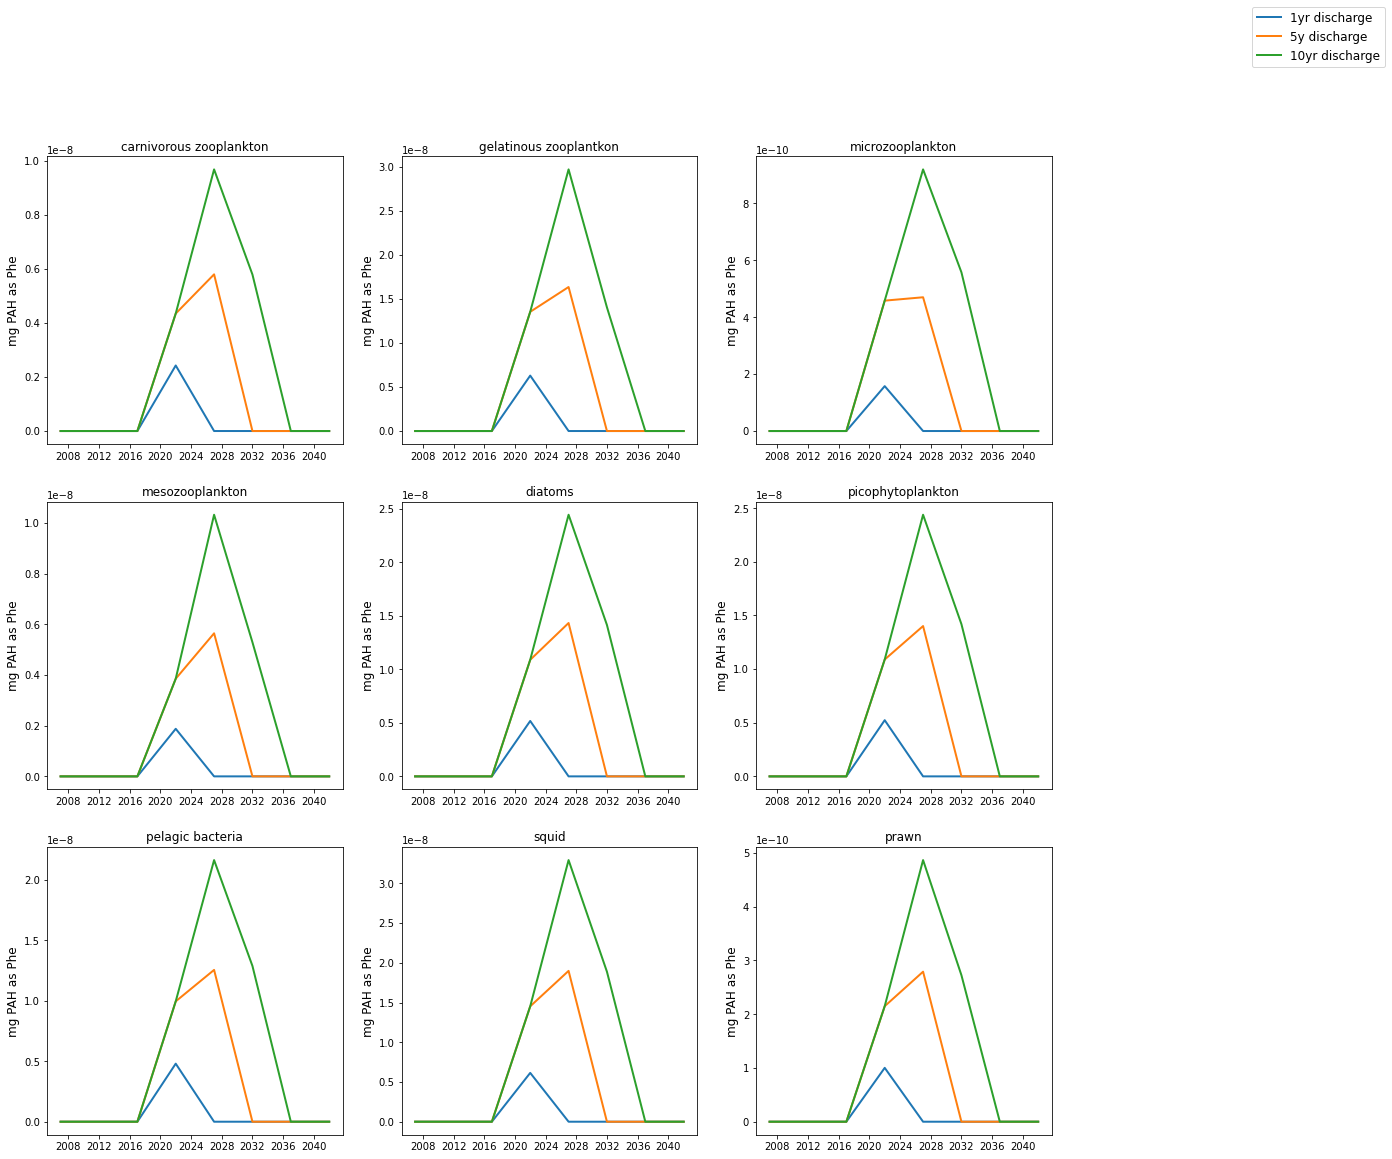

In [38]:
tissue_concentration(groups.planktonic, annual_scenarios)

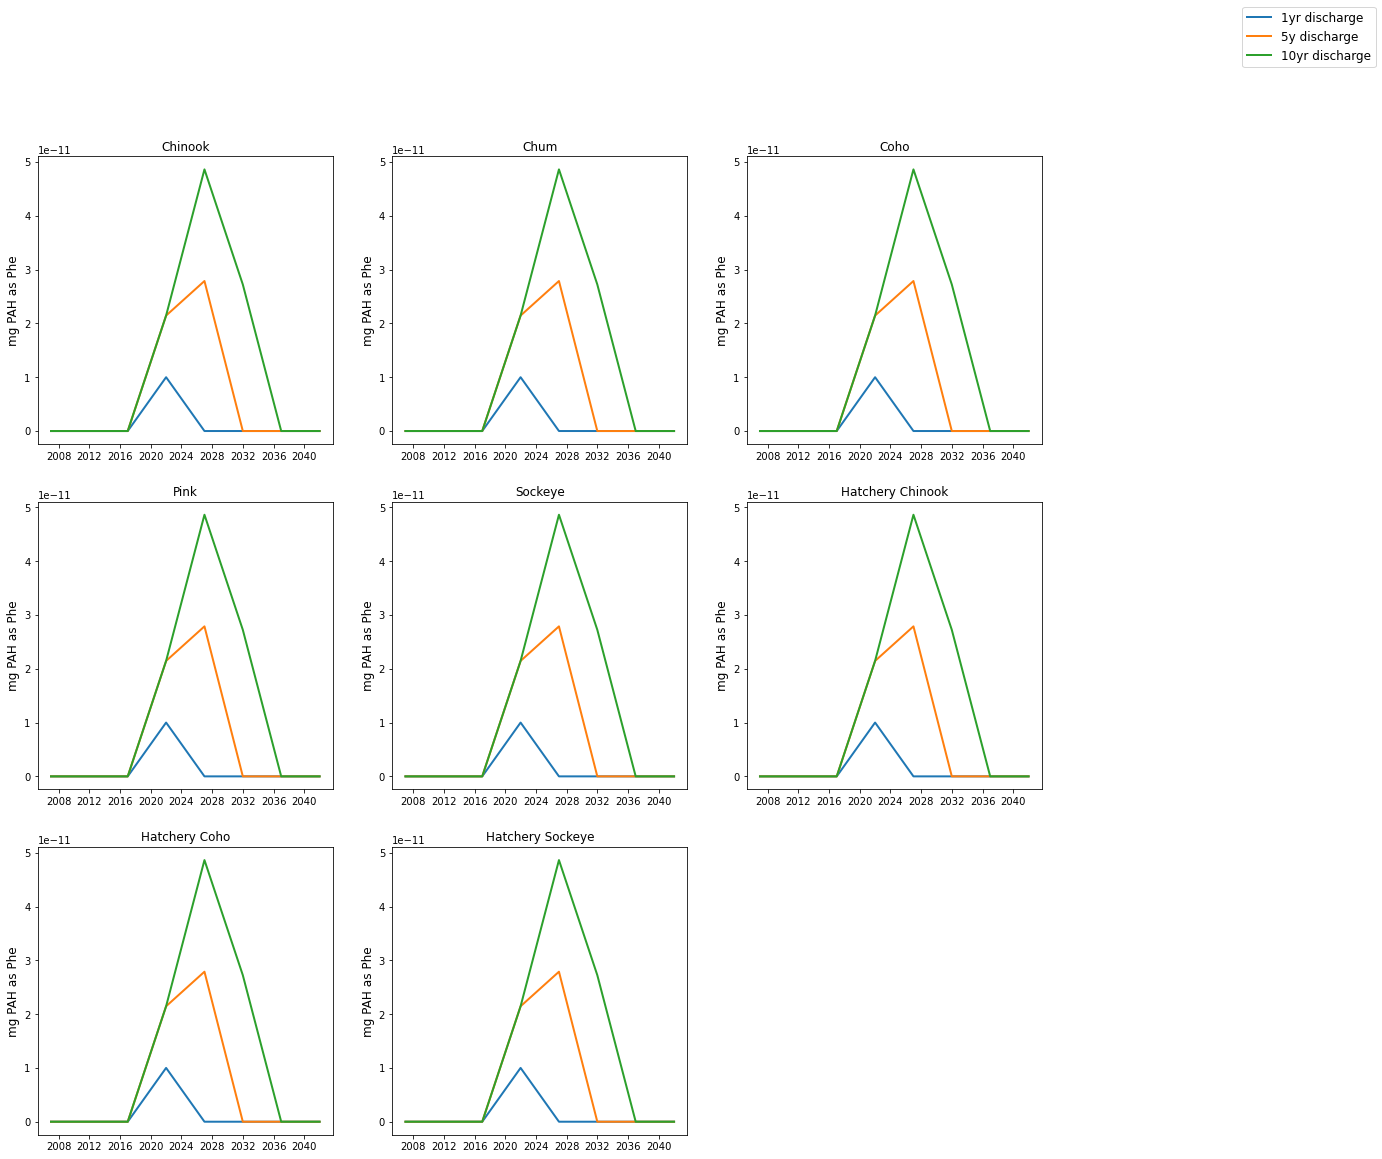

In [39]:
tissue_juveniles_concentration(groups.salmon, annual_scenarios)

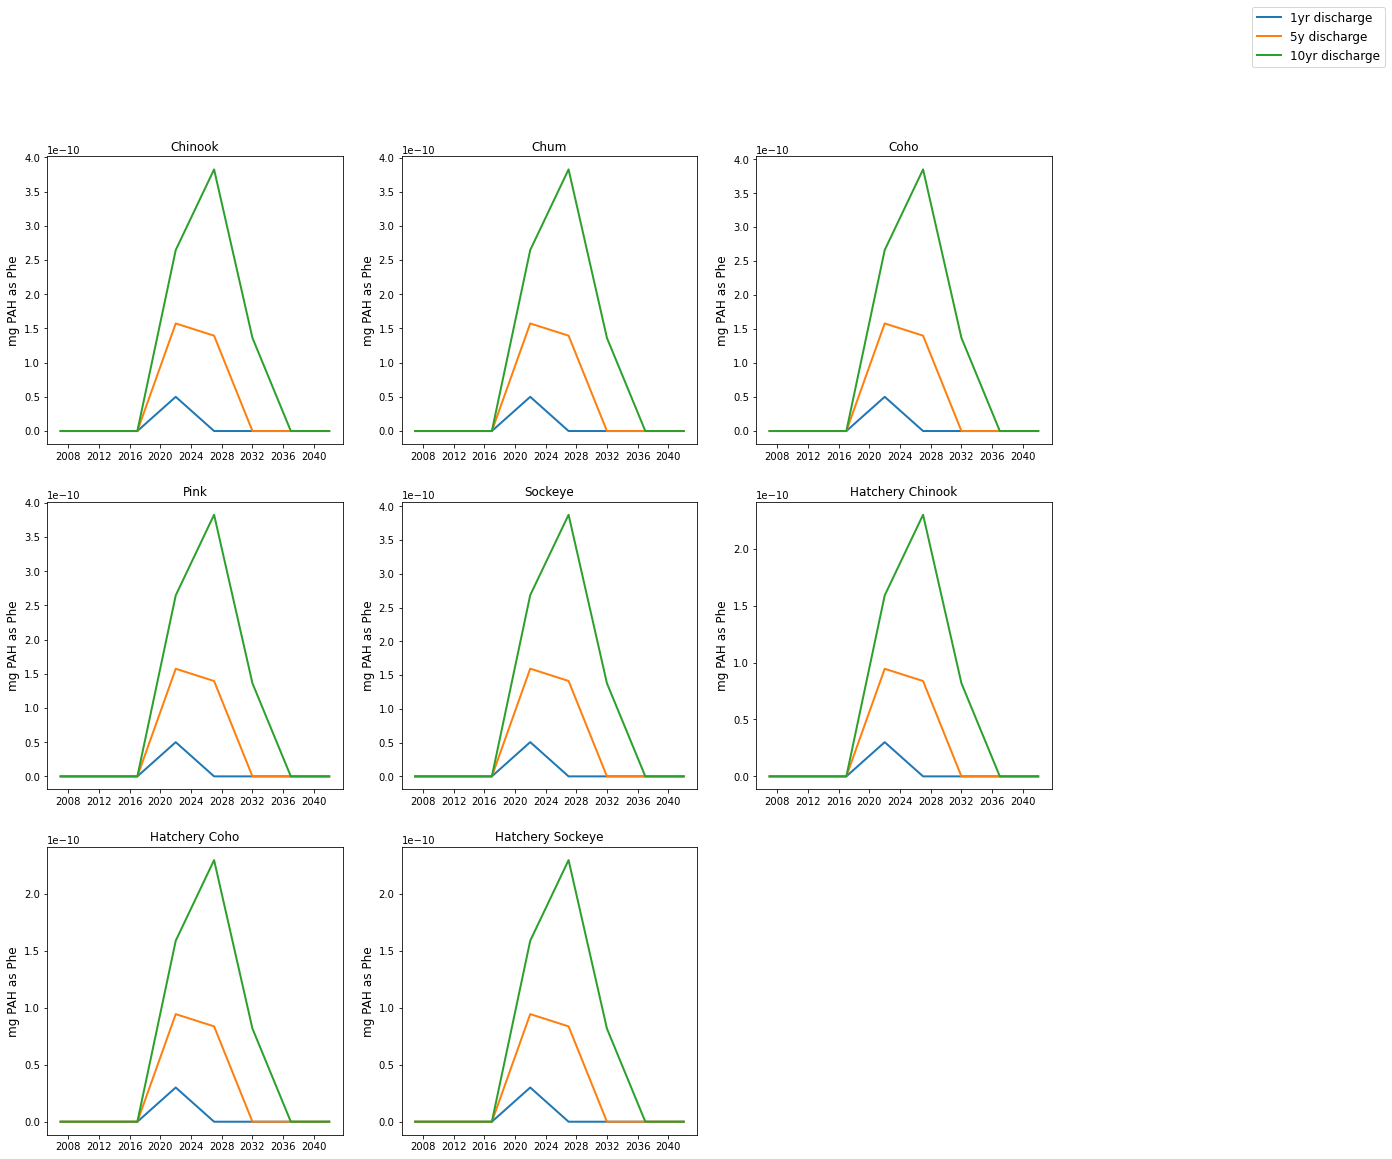

In [42]:
tissue_vertebrate_concentration(groups.salmon, annual_scenarios)

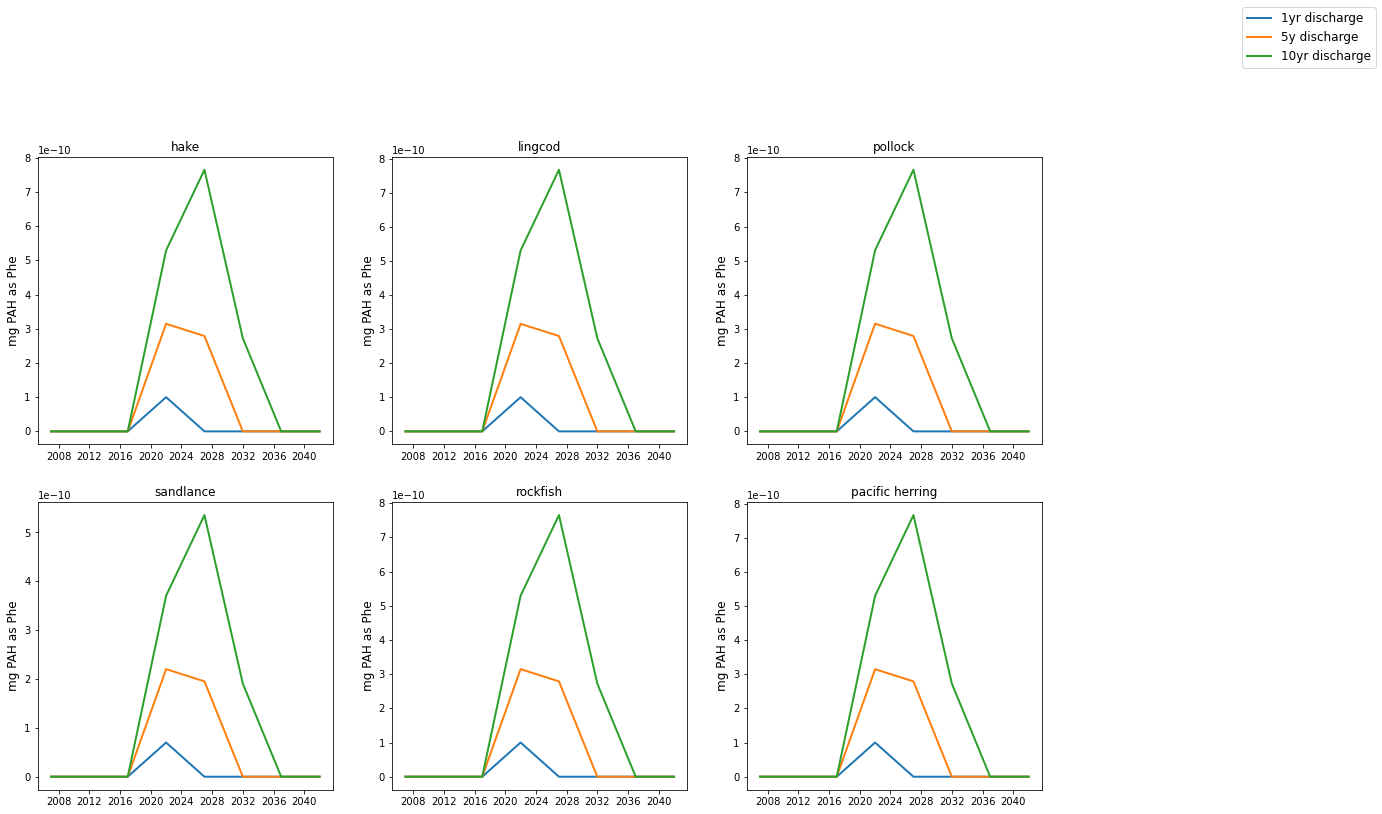

In [43]:
tissue_vertebrate_concentration(groups.named_fish, annual_scenarios)

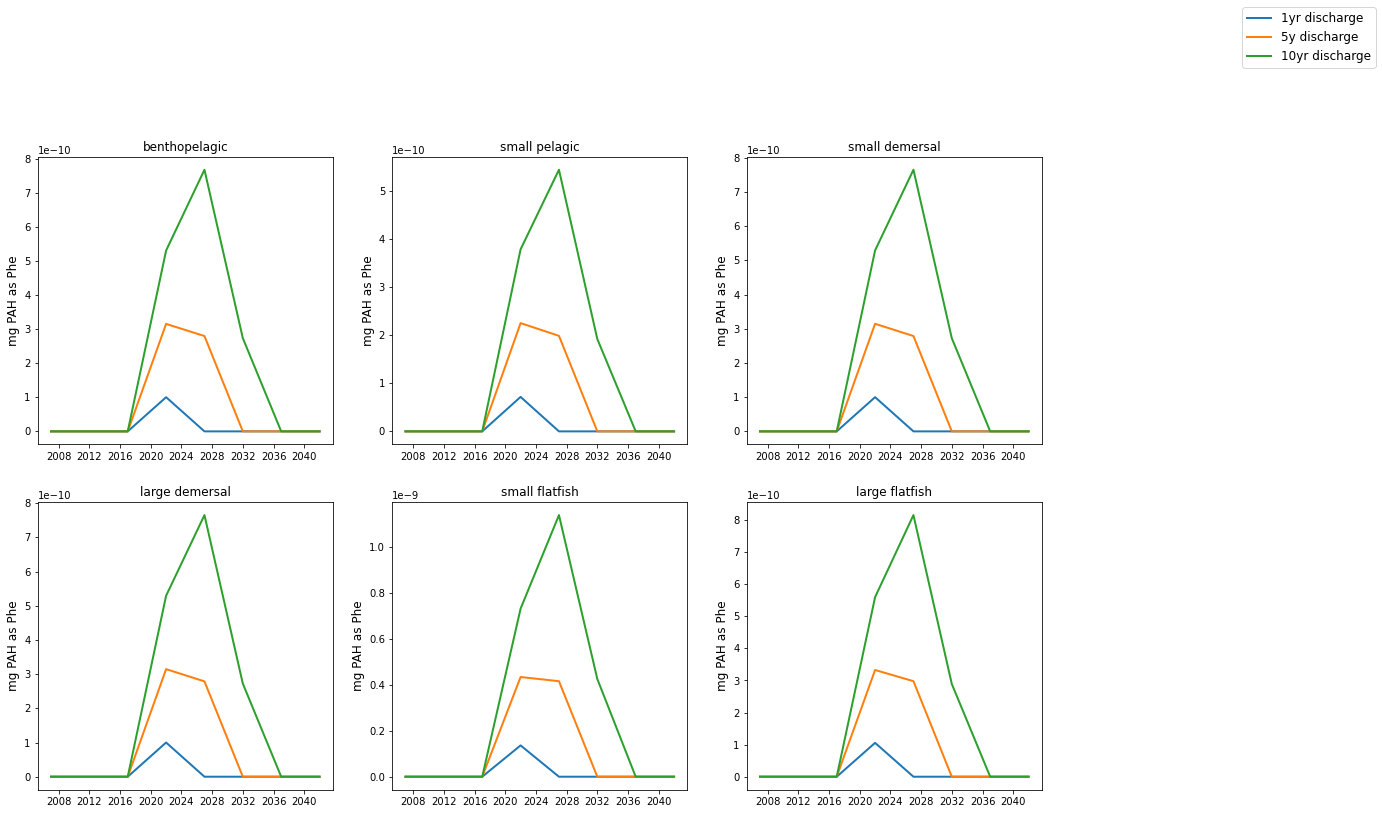

In [44]:
tissue_vertebrate_concentration(groups.other_fish, annual_scenarios)

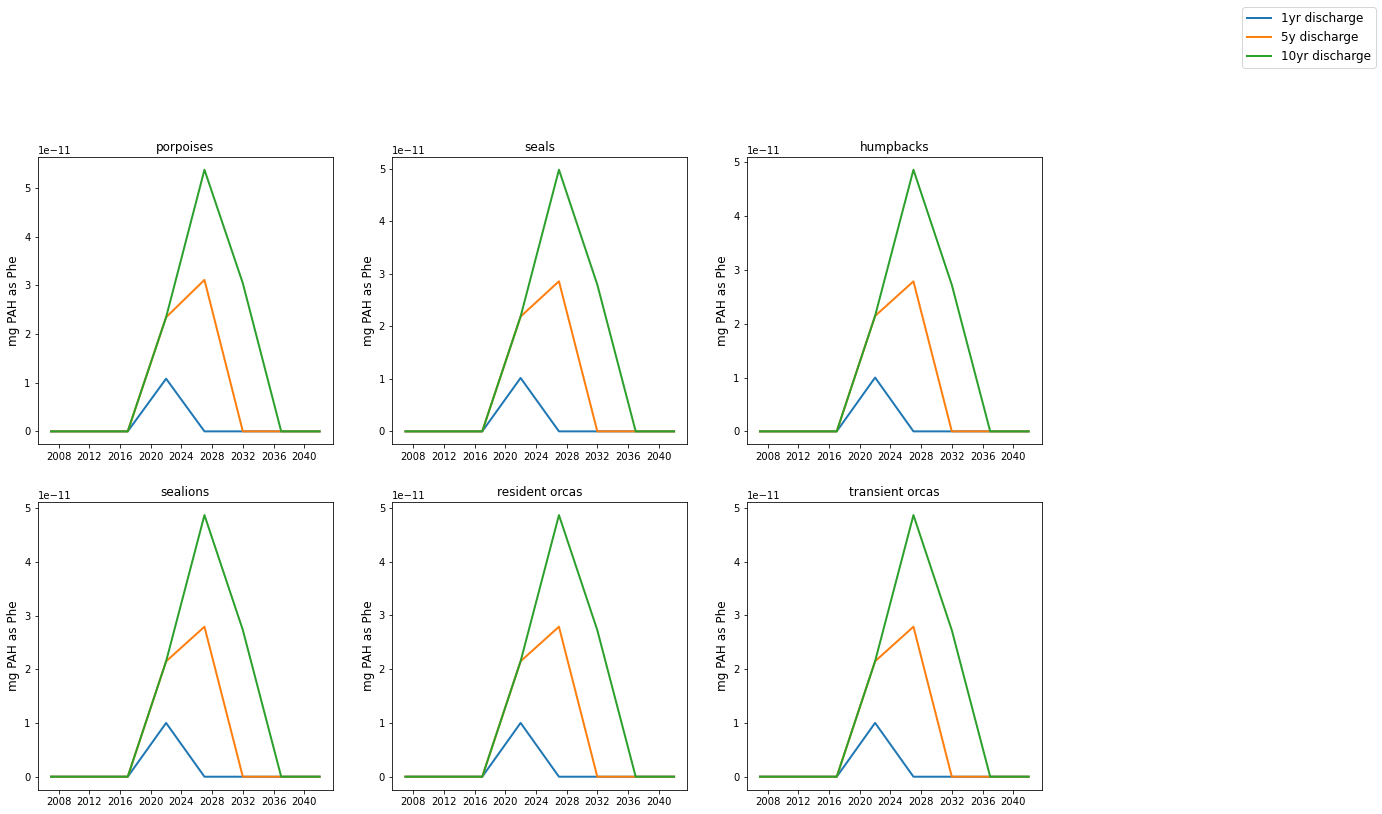

In [45]:
tissue_juveniles_concentration(groups.mammals, annual_scenarios)

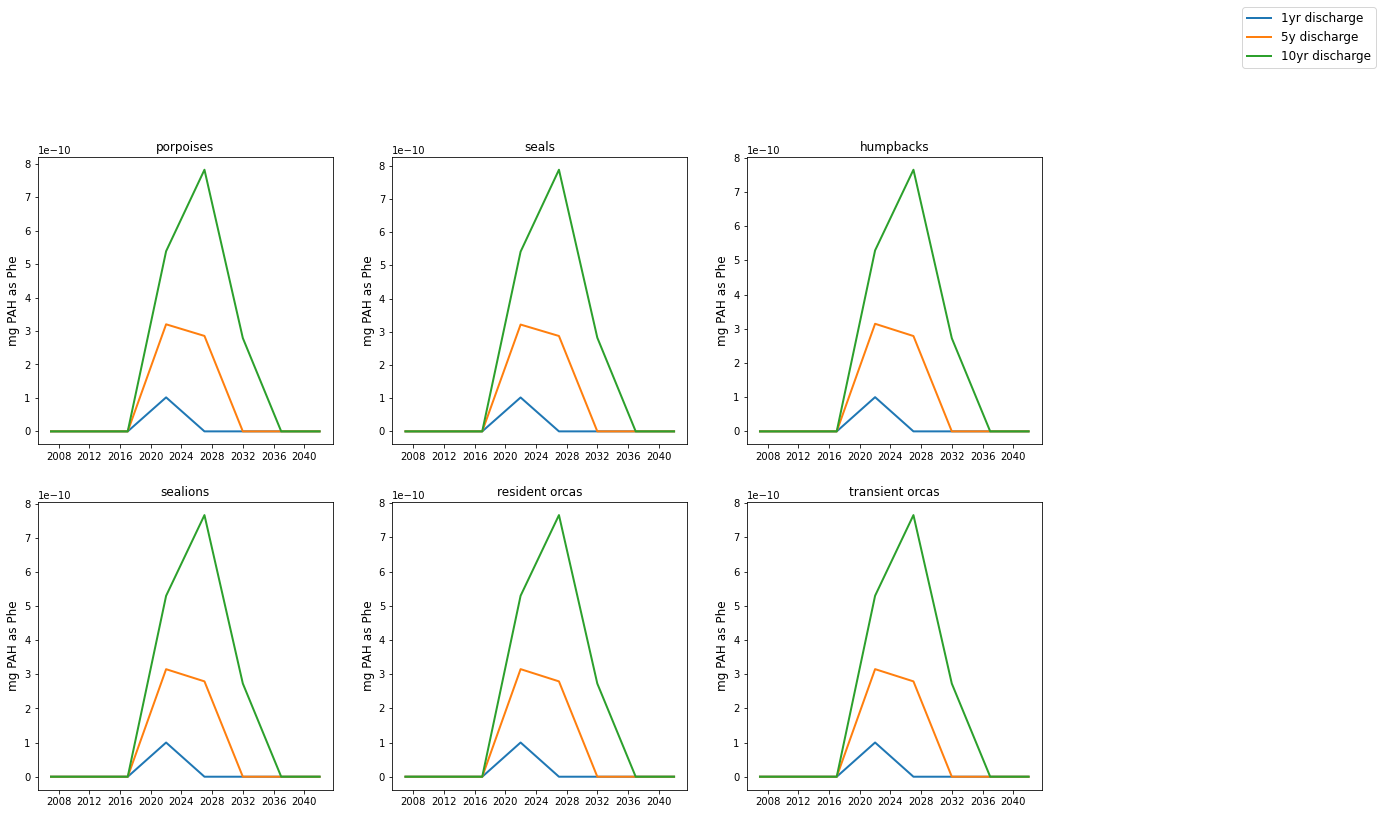

In [46]:
tissue_vertebrate_concentration(groups.mammals, annual_scenarios)

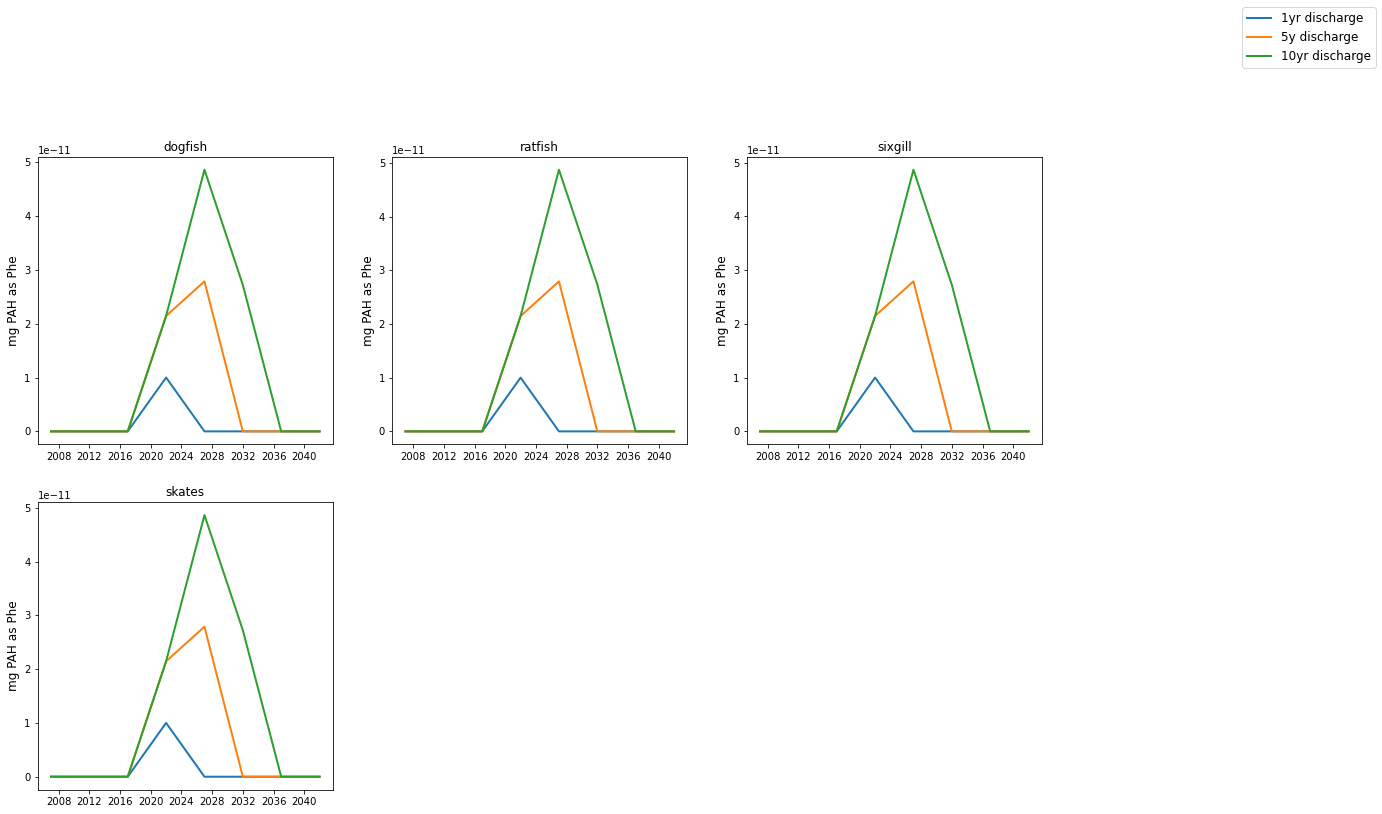

In [47]:
tissue_adults_concentration(groups.sharks, annual_scenarios)

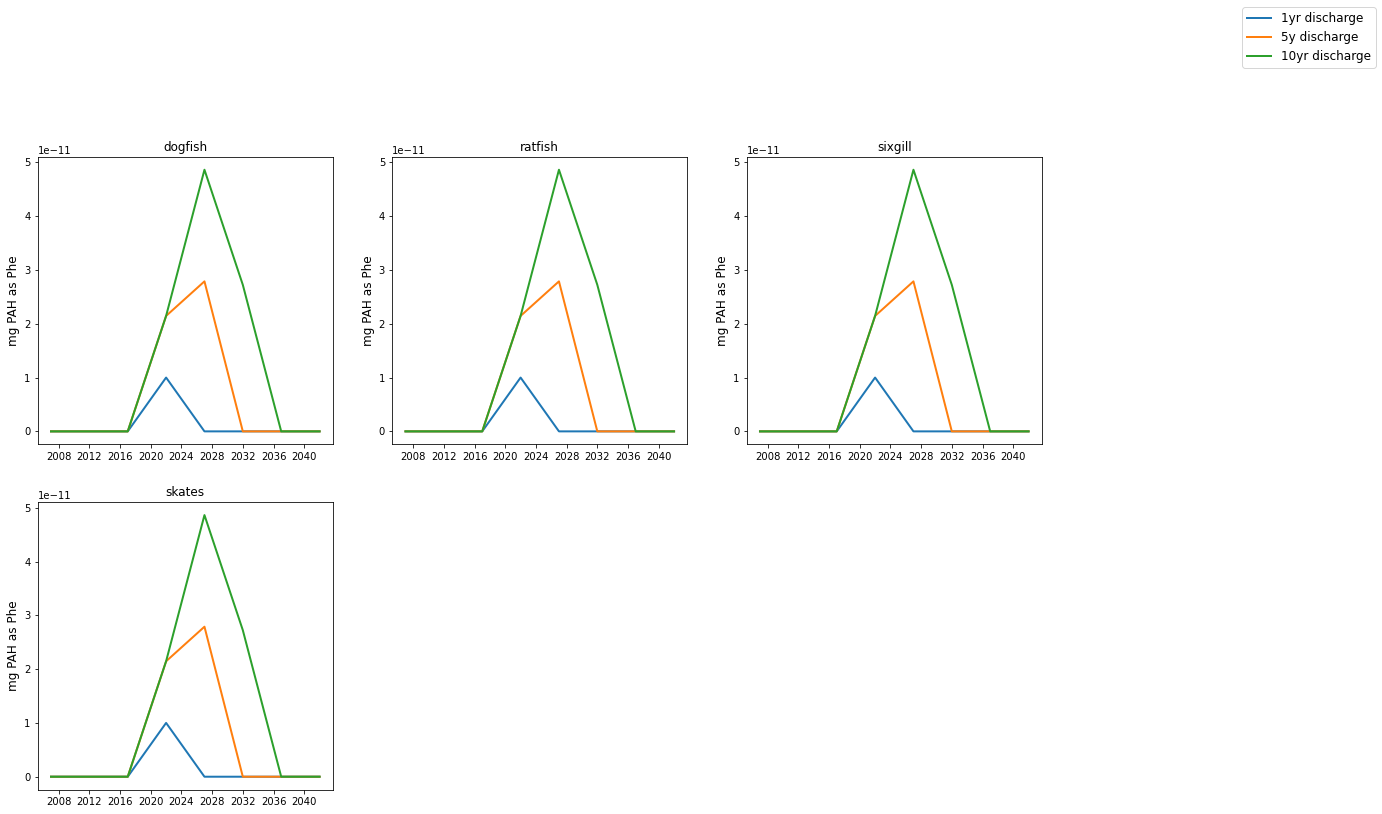

In [49]:
tissue_juveniles_concentration(groups.sharks, annual_scenarios)